In [27]:
import numpy as np


In [28]:
z_mean = 20
noise_param = 0.2
time_steps = 2000
period = 20
A = 5

z_temp = z_mean + A * np.sin(2 * np.pi * np.arange(time_steps) / period) + np.random.normal(loc=0, scale=noise_param, size=time_steps)

In [29]:
# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

In [30]:
import numpy as np

def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    """ Update the estimated state using the dEWMA method. """
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

def mse_between_estimate_and_true(oracle_value, estimated_value):
    """ Compute MSE between the oracle's transmitted value and the push-based estimate. """
    return (oracle_value - estimated_value) ** 2

def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0

    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]
    voi_mse_list = []

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)

        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(z_temp[t] - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = z_temp[t]  # Update the last transmitted value

            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(oracle_last_transmitted_value, x1)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis

        # Update the estimated state
        last_state_value = x1
        last_rate_of_change = x2

    # Return cumulative MSE, transmission count, and recorded VoI comparison points
    return cumulative_mse, transmission_count, voi_mse_list


Cumulative MSE: 0.0
Total Transmissions (Oracle): 366


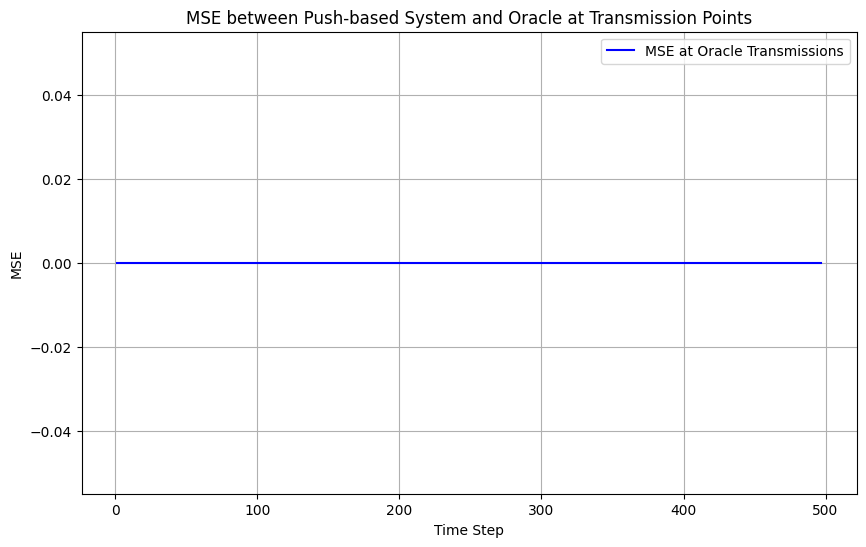

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to update the state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []

    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)

        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(z_temp[t] - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = z_temp[t]  # Update the last transmitted value

            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(oracle_last_transmitted_value, x1)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis

        # Update the estimated state
        last_state_value = x1
        last_rate_of_change = x2

    return cumulative_mse, transmission_count, voi_mse_list

# Generate realistic test values for z_temp
def generate_signal(time_steps, z_mean, A, period, noise_param):
    t = np.arange(time_steps)
    z_temp = z_mean + A * np.sin(2 * np.pi * t / period) + np.random.normal(loc=0, scale=noise_param, size=time_steps)
    return z_temp

# Parameters
time_steps = 500  # Number of time steps
z_mean = 0  # Mean value of the signal
A = 5  # Amplitude of the signal
period = 50  # Period of the sine wave
noise_param = 1  # Noise level
threshold = 0.5  # Threshold for VoI
beta_1 =1  # dEWMA beta_1
beta_2 = 1  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Generate the signal
z_temp = generate_signal(time_steps, z_mean, A, period, noise_param)

# Run the experiment for the push-based system with VoI calculation
cumulative_mse, transmission_count, voi_mse_list = push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Plot the MSE over time at the oracle's transmission points
times, mse_values = zip(*voi_mse_list)
plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Push-based System and Oracle at Transmission Points")
plt.legend()
plt.grid(True)
plt.show()


Cumulative MSE: 0.0
Total Transmissions (Oracle): 441


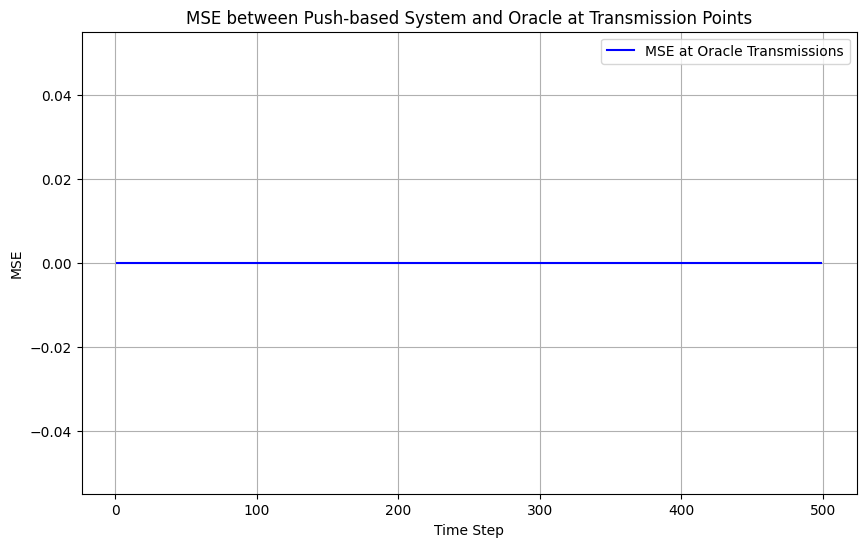

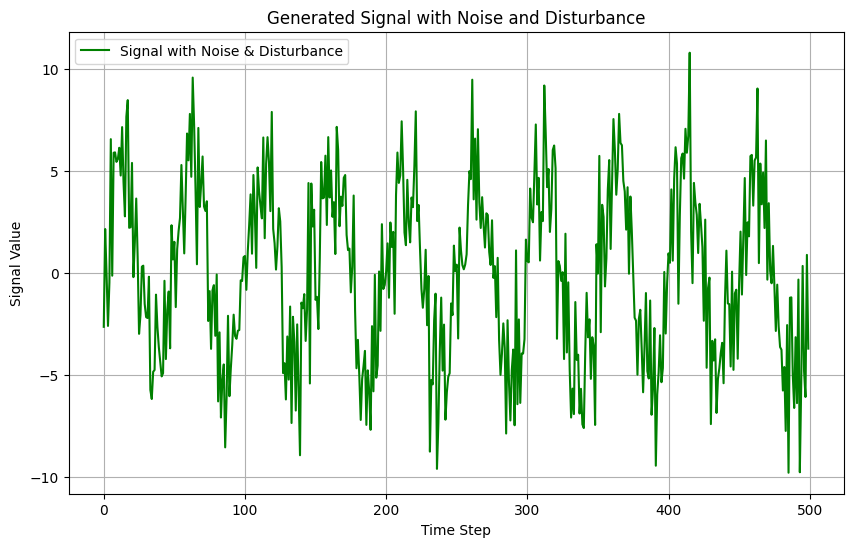

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to update the state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []

    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)

        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(z_temp[t] - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = z_temp[t]  # Update the last transmitted value

            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(oracle_last_transmitted_value, x1)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis

        # Update the estimated state
        last_state_value = x1
        last_rate_of_change = x2

    return cumulative_mse, transmission_count, voi_mse_list

# Generate signal with noise and disturbance
def generate_signal_with_noise_and_disturbance(time_steps, z_mean, A, period, noise_param, disturbance_param):
    t = np.arange(time_steps)
    # Base sinusoidal signal
    z_temp = z_mean + A * np.sin(2 * np.pi * t / period)
    
    # Add noise
    z_temp += np.random.normal(loc=0, scale=noise_param, size=time_steps)
    
    # Add disturbance: random walk or spikes (disturbance_param controls this)
    disturbance = np.random.normal(loc=0, scale=disturbance_param, size=time_steps)
    z_temp += disturbance
    
    return z_temp

# Parameters
time_steps = 500  # Number of time steps
z_mean = 0  # Mean value of the signal
A = 5  # Amplitude of the signal
period = 50  # Period of the sine wave
noise_param = 1  # Noise level
disturbance_param = 2  # Disturbance (random walk or spikes)
threshold = 0.5  # Threshold for VoI
beta_1 = 1  # dEWMA beta_1
beta_2 = 1  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Generate the signal with noise and disturbance
z_temp = generate_signal_with_noise_and_disturbance(time_steps, z_mean, A, period, noise_param, disturbance_param)

# Run the experiment for the push-based system with VoI calculation
cumulative_mse, transmission_count, voi_mse_list = push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Plot the MSE over time at the oracle's transmission points
times, mse_values = zip(*voi_mse_list)
plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Push-based System and Oracle at Transmission Points")
plt.legend()
plt.grid(True)

# Also plot the signal with noise and disturbance for reference
plt.figure(figsize=(10, 6))
plt.plot(z_temp, label="Signal with Noise & Disturbance", color='green')
plt.xlabel("Time Step")
plt.ylabel("Signal Value")
plt.title("Generated Signal with Noise and Disturbance")
plt.legend()
plt.grid(True)
plt.show()


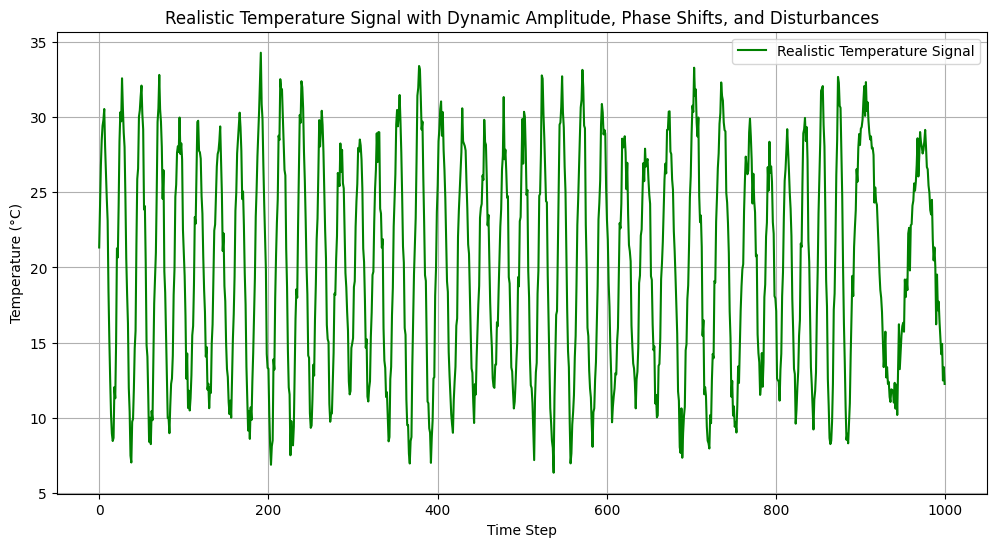

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    # Time points
    t = np.arange(0, total_time, time_resolution)

    # Dynamic amplitude that changes over time (weekly variation)
    amplitude_variation = 10 + 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation

    # Random phase shifts (introduce variability in the start of the sine wave)
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))

    # Irregular periods (simulate variations in daily cycles)
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    # Generate base temperature with dynamic amplitude and random phase shifts
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg

    # Add noise to the signal
    noise = np.random.normal(0, noise_amplitude, len(t))

    # Add occasional random disturbances (random spikes or drops in temperature)
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    # Combine the components: dynamic temperature, noise, and disturbances
    T_realistic = T_dynamic + noise + disturbances

    return t, T_realistic

# Parameters for the signal
total_time = 1000  # Total simulation time (in hours or time units)
time_resolution = 1  # Time step resolution (in hours or time units)
T_avg = 20  # Average temperature
T_period = 24  # Period of the temperature cycle (daily cycle, 24 hours)
noise_amplitude = 1  # Amplitude of the noise
disturbance_probability = 0.01  # Probability of a disturbance occurring at each time step

# Generate the realistic temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Plot the generated temperature signal
plt.figure(figsize=(12, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Realistic Temperature Signal with Dynamic Amplitude, Phase Shifts, and Disturbances")
plt.legend()
plt.grid(True)
plt.show()


Cumulative MSE: 40.98002675594857
Total Transmissions (Oracle): 849


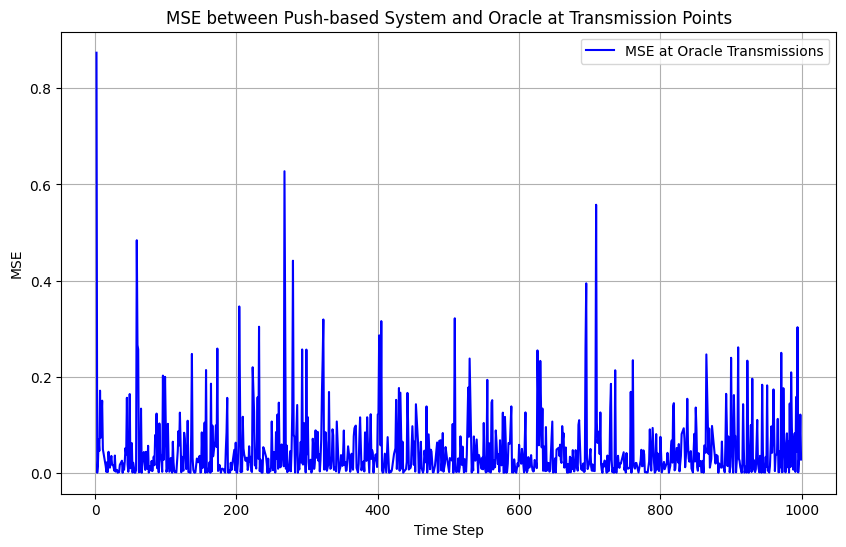

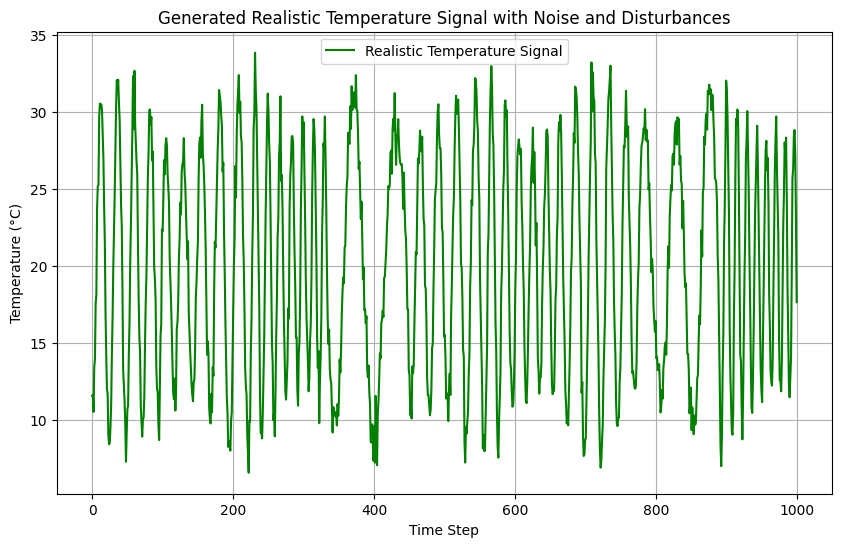

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []

    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)

        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(z_temp[t] - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = z_temp[t]  # Update the last transmitted value

            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(oracle_last_transmitted_value, x1)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis

        # Update the estimated state
        last_state_value = x1
        last_rate_of_change = x2

    return cumulative_mse, transmission_count, voi_mse_list

# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    # Time points
    t = np.arange(0, total_time, time_resolution)

    # Dynamic amplitude that changes over time (weekly variation)
    amplitude_variation = 10 + 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation

    # Random phase shifts (introduce variability in the start of the sine wave)
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))

    # Irregular periods (simulate variations in daily cycles)
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    # Generate base temperature with dynamic amplitude and random phase shifts
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg

    # Add noise to the signal
    noise = np.random.normal(0, noise_amplitude, len(t))

    # Add occasional random disturbances (random spikes or drops in temperature)
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    # Combine the components: dynamic temperature, noise, and disturbances
    T_realistic = T_dynamic + noise + disturbances

    return t, T_realistic

# Parameters for the signal
total_time = 1000  # Total simulation time (in hours or time units)
time_resolution = 1  # Time step resolution (in hours or time units)
T_avg = 20  # Average temperature
T_period = 24  # Period of the temperature cycle (daily cycle, 24 hours)
noise_amplitude = 1  # Amplitude of the noise
disturbance_probability = 0.01  # Probability of a disturbance occurring at each time step

# Generate the realistic temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Parameters for the push-based system
threshold = 0.5  # Threshold for VoI
beta_1 = 0.9  # dEWMA beta_1
beta_2 = 0.9  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Run the experiment for the push-based system with VoI calculation
cumulative_mse, transmission_count, voi_mse_list = push_based_system_voi(T_realistic, total_time, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Plot the MSE over time at the oracle's transmission points
times, mse_values = zip(*voi_mse_list)
plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Push-based System and Oracle at Transmission Points")
plt.legend()
plt.grid(True)

# Also plot the generated temperature signal with noise and disturbances
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Generated Realistic Temperature Signal with Noise and Disturbances")
plt.legend()
plt.grid(True)
plt.show()


Cumulative MSE: 1.659326062219722
Total Transmissions (Oracle): 497


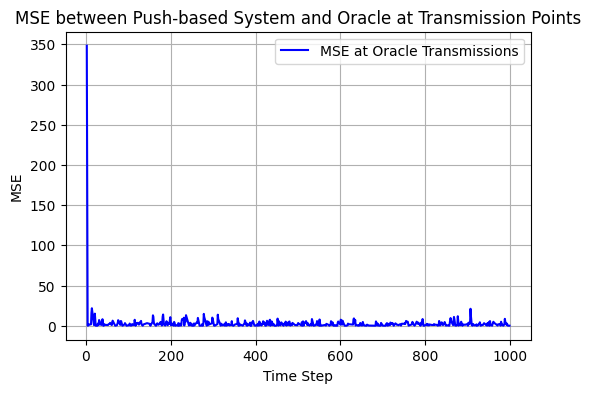

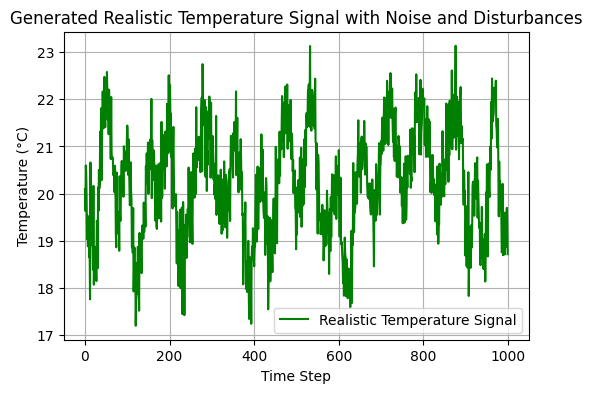

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []
    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)

        # Calculate the predicted value using the rate of change and time elapsed
        predicted_value = last_state_value + (last_rate_of_change * delta_t)

        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(measured_value - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = measured_value  # Update the last transmitted value

            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(predicted_value, measured_value)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis

        # Update the estimated state
        last_state_value = x1
        last_rate_of_change = x2
    cumulative_mse =cumulative_mse/time_steps

    return cumulative_mse, transmission_count, voi_mse_list


# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    # Time points
    t = np.arange(0, total_time, time_resolution)

    # Dynamic amplitude that changes over time (weekly variation)
    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation

    # Random phase shifts (introduce variability in the start of the sine wave)
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))

    # Irregular periods (simulate variations in daily cycles)
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    # Generate base temperature with dynamic amplitude and random phase shifts
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg

    # Add noise to the signal
    noise = np.random.normal(0, noise_amplitude, len(t))

    # Add occasional random disturbances (random spikes or drops in temperature)
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    # Combine the components: dynamic temperature, noise, and disturbances
    T_realistic = T_dynamic + noise + disturbances

    return t, T_realistic

# Parameters for the signal
total_time = 1000  # Total simulation time (in hours or time units)
time_resolution = 1  # Time step resolution (in hours or time units)
T_avg = 20  # Average temperature
T_period = 100  # Period of the temperature cycle (daily cycle, 24 hours)
noise_amplitude = 0.5  # Amplitude of the noise
disturbance_probability = 0  # Probability of a disturbance occurring at each time step

# Generate the realistic temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Parameters for the push-based system
threshold = 0.5  # Threshold for VoI
beta_1 = 1 # dEWMA beta_1
beta_2 = 1  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Run the experiment for the push-based system with VoI calculation
cumulative_mse, transmission_count, voi_mse_list = push_based_system_voi(T_realistic, total_time, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Plot the MSE over time at the oracle's transmission points
times, mse_values = zip(*voi_mse_list)
plt.figure(figsize=(6, 4))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Push-based System and Oracle at Transmission Points")
plt.legend()
plt.grid(True)

# Also plot the generated temperature signal with noise and disturbances
plt.figure(figsize=(6, 4))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Generated Realistic Temperature Signal with Noise and Disturbances")
plt.legend()
plt.grid(True)
plt.show()


Cumulative MSE: 0.003541517089357109
Total Transmissions (Oracle): 93


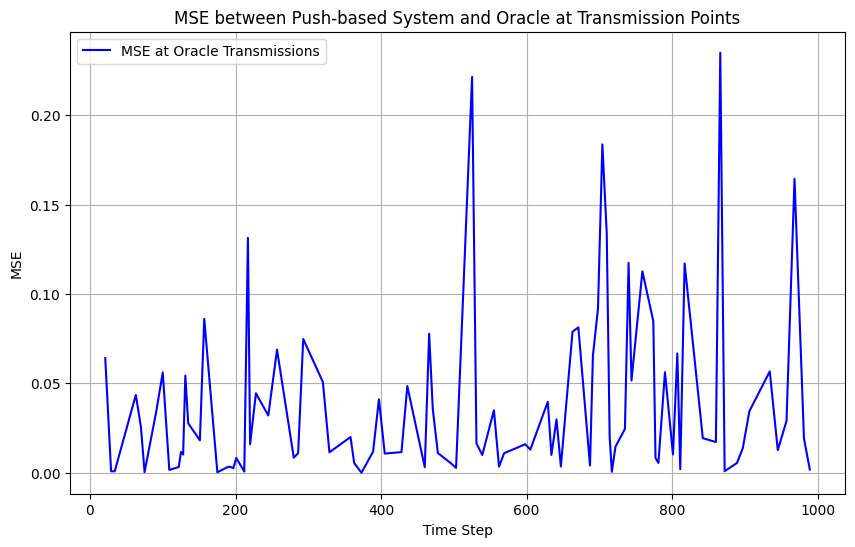

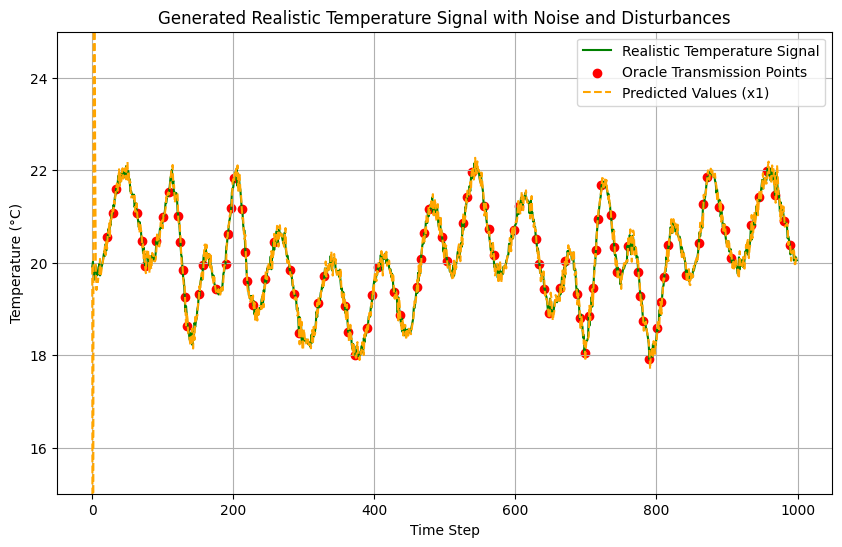

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []
    
    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]
    predicted_values = [z_temp[0]]  # Initialize with the first value (for t=0)
    oracle_transmission_times = []  # To store the times when oracle transmits

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)

        # Calculate the predicted value using the rate of change and time elapsed
        predicted_value = last_state_value + (last_rate_of_change * delta_t)
        predicted_values.append(predicted_value)

        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(measured_value - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = measured_value  # Update the last transmitted value
            oracle_transmission_times.append(t)  # Store the time of oracle transmission

            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(predicted_value, measured_value)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis

        # Update the estimated state
        last_state_value = x1
        last_rate_of_change = x2

    cumulative_mse = cumulative_mse / time_steps

    return cumulative_mse, transmission_count, voi_mse_list, predicted_values, oracle_transmission_times



# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    # Time points
    t = np.arange(0, total_time, time_resolution)

    # Dynamic amplitude that changes over time (weekly variation)
    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation

    # Random phase shifts (introduce variability in the start of the sine wave)
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))

    # Irregular periods (simulate variations in daily cycles)
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    # Generate base temperature with dynamic amplitude and random phase shifts
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg

    # Add noise to the signal
    noise = np.random.normal(0, noise_amplitude, len(t))

    # Add occasional random disturbances (random spikes or drops in temperature)
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    # Combine the components: dynamic temperature, noise, and disturbances
    T_realistic = T_dynamic + noise + disturbances

    return t, T_realistic

# Parameters for the signal
total_time = 1000  # Total simulation time (in hours or time units)
time_resolution = 1  # Time step resolution (in hours or time units)
T_avg = 20  # Average temperature
T_period = 100  # Period of the temperature cycle (daily cycle, 24 hours)
noise_amplitude = 0.1 # Amplitude of the noise
disturbance_probability = 0  # Probability of a disturbance occurring at each time step

# Generate the realistic temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Parameters for the push-based system
threshold = 0.5  # Threshold for VoI
beta_1 = 0.8 # dEWMA beta_1
beta_2 = 0.8  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Run the experiment for the push-based system with VoI calculation
cumulative_mse, transmission_count, voi_mse_list, predicted_values, oracle_transmission_times = push_based_system_voi(T_realistic, total_time, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Plot the MSE over time at the oracle's transmission points
times, mse_values = zip(*voi_mse_list)
plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Push-based System and Oracle at Transmission Points")
plt.legend()
plt.grid(True)

# Also plot the generated temperature signal with noise and disturbances
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Generated Realistic Temperature Signal with Noise and Disturbances")
plt.ylim(15,25)

# Highlight the points where the oracle transmits (VoI condition met)
plt.scatter(oracle_transmission_times, np.array(T_realistic)[oracle_transmission_times], color='red', label='Oracle Transmission Points')

# Plot the predicted values (based on x1 from dEWMA)
plt.plot(t, predicted_values, label="Predicted Values (x1)", color='orange', linestyle='--')

plt.legend()
plt.grid(True)
plt.show()


Cumulative MSE: 0.0035600284124418916
Total Transmissions (Oracle): 94


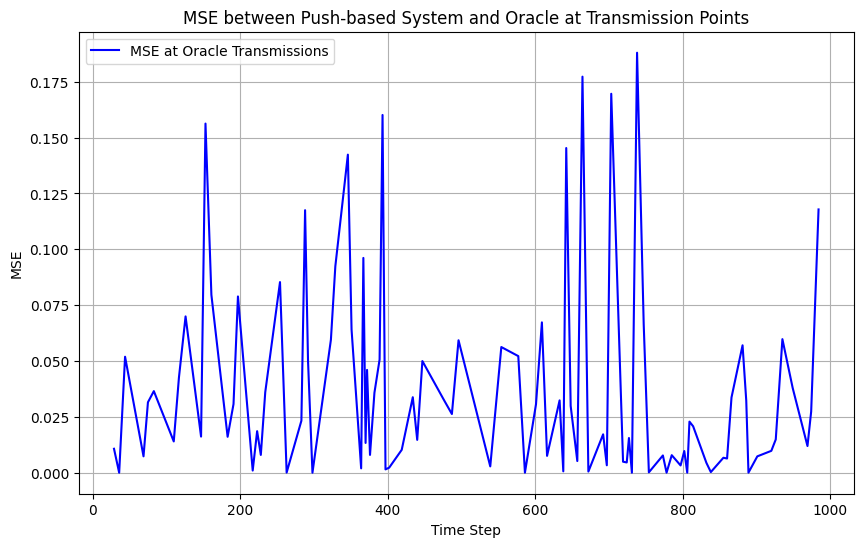

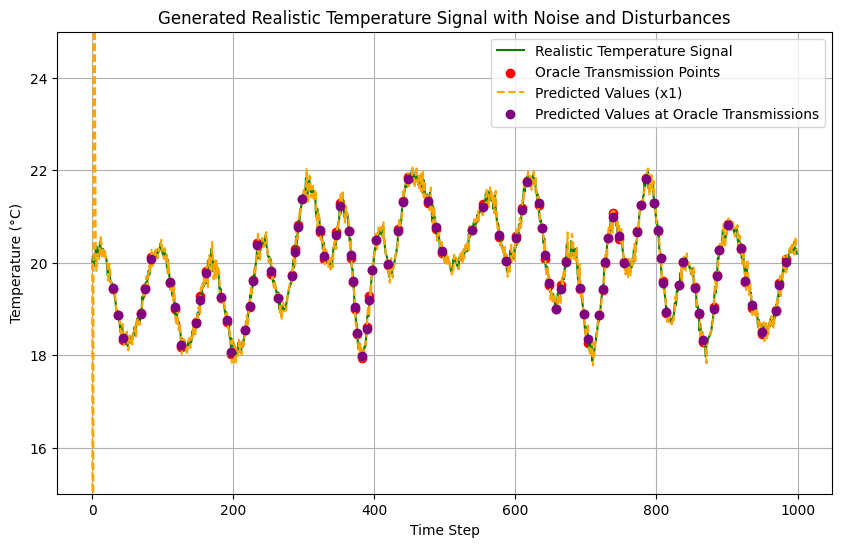

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []
    
    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]
    predicted_values = [z_temp[0]]  # Initialize with the first value (for t=0)
    oracle_transmission_times = []  # To store the times when oracle transmits
    predicted_at_transmissions = []  # To store predicted values at oracle transmission points

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)

        # Calculate the predicted value using the rate of change and time elapsed
        predicted_value = last_state_value + (last_rate_of_change * delta_t)
        predicted_values.append(predicted_value)

        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(measured_value - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = measured_value  # Update the last transmitted value
            oracle_transmission_times.append(t)  # Store the time of oracle transmission
            predicted_at_transmissions.append(x1)  # Store the predicted value at this transmission point

            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(predicted_value, measured_value)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis

        # Update the estimated state
        last_state_value = x1
        last_rate_of_change = x2

    cumulative_mse = cumulative_mse / time_steps

    return cumulative_mse, transmission_count, voi_mse_list, predicted_values, oracle_transmission_times, predicted_at_transmissions


# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)

    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic


# Parameters for the signal
total_time = 1000  # Total simulation time (in hours or time units)
time_resolution = 1  # Time step resolution (in hours or time units)
T_avg = 20  # Average temperature
T_period = 100  # Period of the temperature cycle (daily cycle, 24 hours)
noise_amplitude = 0.1  # Amplitude of the noise
disturbance_probability = 0  # Probability of a disturbance occurring at each time step

# Generate the realistic temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Parameters for the push-based system
threshold = 0.5  # Threshold for VoI
beta_1 = 0.8  # dEWMA beta_1
beta_2 = 0.8  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Run the experiment for the push-based system with VoI calculation
cumulative_mse, transmission_count, voi_mse_list, predicted_values, oracle_transmission_times, predicted_at_transmissions = push_based_system_voi(T_realistic, total_time, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Plot the MSE over time at the oracle's transmission points
times, mse_values = zip(*voi_mse_list)
plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Push-based System and Oracle at Transmission Points")
plt.legend()
plt.grid(True)

# Plot the generated temperature signal with noise and disturbances
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Generated Realistic Temperature Signal with Noise and Disturbances")
plt.ylim(15, 25)

# Highlight the points where the oracle transmits (VoI condition met)
plt.scatter(oracle_transmission_times, np.array(T_realistic)[oracle_transmission_times], color='red', label='Oracle Transmission Points')

# Plot the predicted values (based on x1 from dEWMA)
plt.plot(t, predicted_values, label="Predicted Values (x1)", color='orange', linestyle='--')

# Plot the predicted values at oracle transmission points (x1 at transmission times)
plt.scatter(oracle_transmission_times, predicted_at_transmissions, color='purple', label="Predicted Values at Oracle Transmissions", zorder=5)

plt.legend()
plt.grid(True)
plt.show()


Cumulative MSE: 0.004743762968302036
Total Transmissions (Oracle): 105


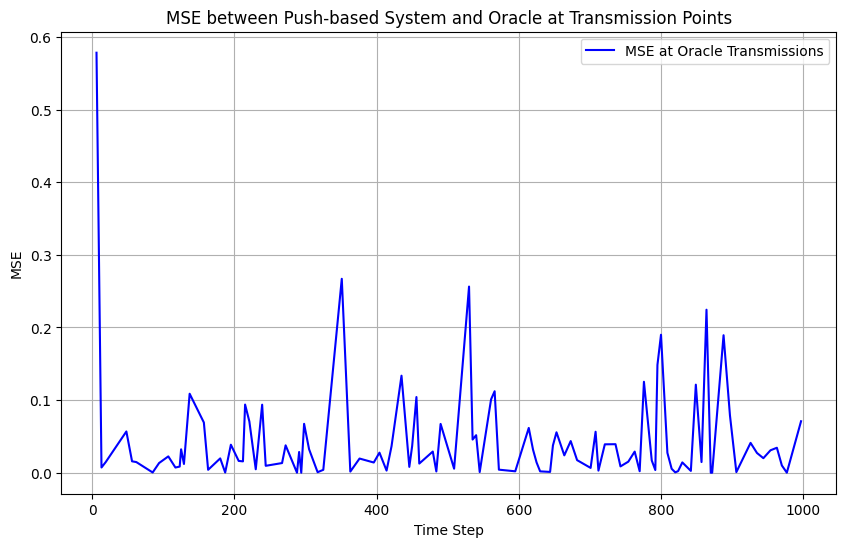

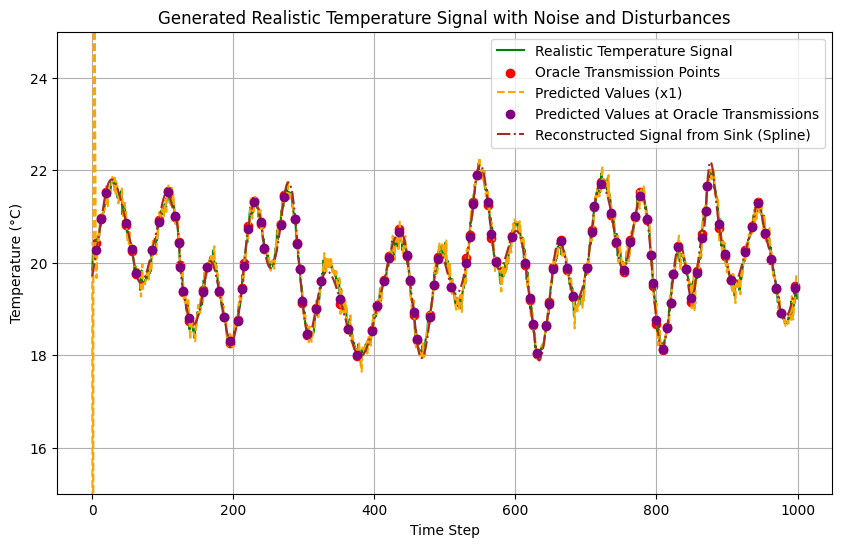

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []
    
    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]
    predicted_values = [z_temp[0]]  # Initialize with the first value (for t=0)
    oracle_transmission_times = []  # To store the times when oracle transmits
    predicted_at_transmissions = []  # To store predicted values at oracle transmission points
    transmitted_values = []  # To store transmitted values (x1 and x2)

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)

        # Calculate the predicted value using the rate of change and time elapsed
        predicted_value = last_state_value + (last_rate_of_change * delta_t)
        predicted_values.append(predicted_value)

        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(measured_value - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = measured_value  # Update the last transmitted value
            oracle_transmission_times.append(t)  # Store the time of oracle transmission
            predicted_at_transmissions.append(x1)  # Store the predicted value at this transmission point
            transmitted_values.append((t, x1, x2))  # Store both x1 and x2 at the transmission points

            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(predicted_value, measured_value)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis

        # Update the estimated state
        last_state_value = x1
        last_rate_of_change = x2

    cumulative_mse = cumulative_mse / time_steps

    return cumulative_mse, transmission_count, voi_mse_list, predicted_values, oracle_transmission_times, predicted_at_transmissions, transmitted_values


# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)

    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic


# Parameters for the signal
total_time = 1000  # Total simulation time (in hours or time units)
time_resolution = 1  # Time step resolution (in hours or time units)
T_avg = 20  # Average temperature
T_period = 100  # Period of the temperature cycle (daily cycle, 24 hours)
noise_amplitude = 0.1  # Amplitude of the noise
disturbance_probability = 0  # Probability of a disturbance occurring at each time step

# Generate the realistic temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Parameters for the push-based system
threshold = 0.5  # Threshold for VoI
beta_1 = 0.8  # dEWMA beta_1
beta_2 = 0.8  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Run the experiment for the push-based system with VoI calculation
cumulative_mse, transmission_count, voi_mse_list, predicted_values, oracle_transmission_times, predicted_at_transmissions, transmitted_values = push_based_system_voi(T_realistic, total_time, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Plot the MSE over time at the oracle's transmission points
times, mse_values = zip(*voi_mse_list)
plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Push-based System and Oracle at Transmission Points")
plt.legend()
plt.grid(True)

# Plot the generated temperature signal with noise and disturbances
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Generated Realistic Temperature Signal with Noise and Disturbances")
plt.ylim(15, 25)

# Highlight the points where the oracle transmits (VoI condition met)
plt.scatter(oracle_transmission_times, np.array(T_realistic)[oracle_transmission_times], color='red', label='Oracle Transmission Points')

# Plot the predicted values (based on x1 from dEWMA)
plt.plot(t, predicted_values, label="Predicted Values (x1)", color='orange', linestyle='--')

# Plot the predicted values at oracle transmission points (x1 at transmission times)
plt.scatter(oracle_transmission_times, predicted_at_transmissions, color='purple', label="Predicted Values at Oracle Transmissions", zorder=5)

# Reconstruct the temperature path using spline interpolation from transmitted data
transmitted_times, transmitted_x1_values, transmitted_x2_values = zip(*transmitted_values)

# Spline fitting: Use cubic spline interpolation to reconstruct the signal
spline_reconstruction = CubicSpline(transmitted_times, transmitted_x1_values, bc_type='natural')
reconstructed_signal = spline_reconstruction(t)

# Plot the reconstructed signal
plt.plot(t, reconstructed_signal, label="Reconstructed Signal from Sink (Spline)", color='brown', linestyle='-.')

plt.legend()
plt.grid(True)
plt.show()


Cumulative MSE: 1.8177912431006236
Total Transmissions (Oracle): 548


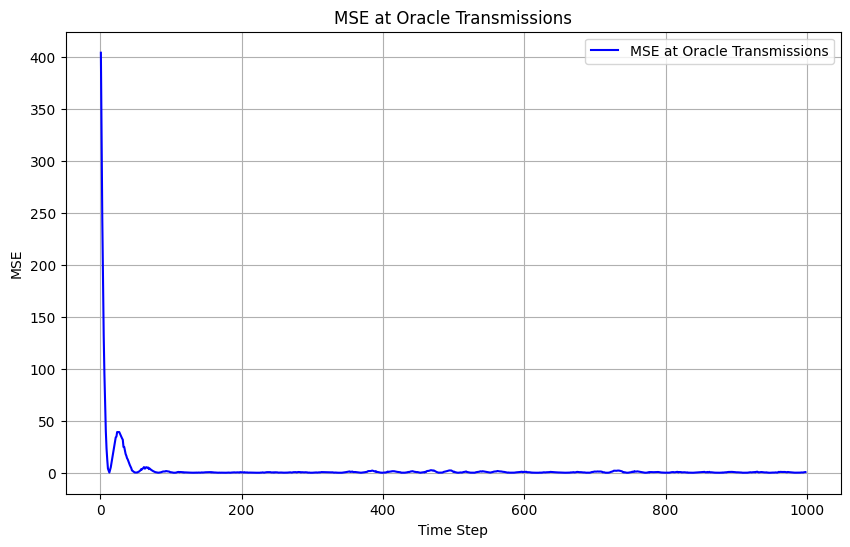

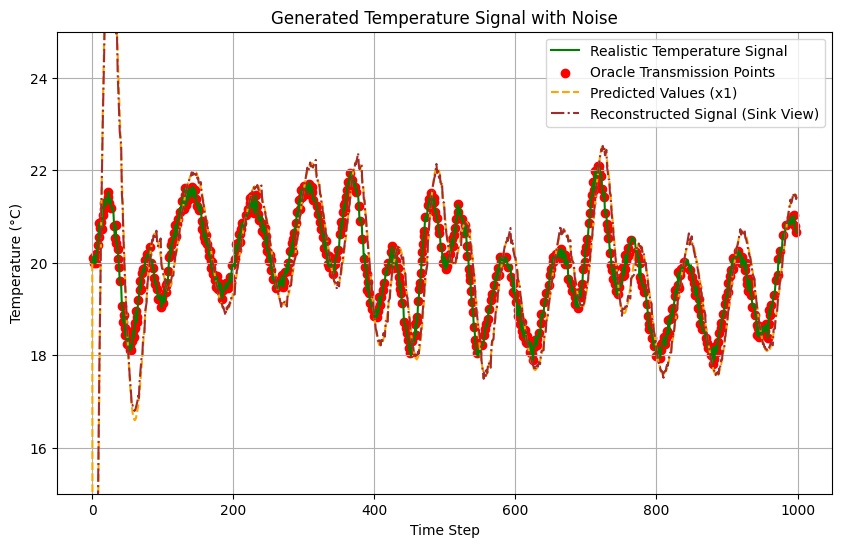

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate push-based system with VoI
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []
    
    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]
    predicted_values = [z_temp[0]]  # Initialize with first value (for t=0)
    oracle_transmission_times = []  # To store transmission times
    transmitted_values = []  # Store transmitted (x1, x2)
    reconstructed_values = np.zeros(time_steps)  # Placeholder for reconstruction

    last_transmission_time = 0  # Track last transmission time
    last_transmitted_x1 = z_temp[0]  # Last transmitted point-in-time value
    last_transmitted_x2 = 0  # Last transmitted rate of change

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)

        # Calculate the predicted value using the rate of change
        predicted_value = last_state_value + (last_rate_of_change * delta_t)
        predicted_values.append(predicted_value)

        # If the VoI exceeds the threshold, send transmission
        if np.abs(measured_value - oracle_last_transmitted_value) > threshold:
            oracle_last_transmitted_value = measured_value  # Update transmitted value
            oracle_transmission_times.append(t)  # Store time of transmission
            transmitted_values.append((t, x1, x2))  # Store transmitted values
            
            # Update last transmission details for reconstruction
            last_transmission_time = t
            last_transmitted_x1 = x1
            last_transmitted_x2 = x2

            # MSE Calculation
            mse = mse_between_estimate_and_true(predicted_value, measured_value)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis

        # **Reconstruct Signal at Sink Side**
        reconstructed_values[t] = last_transmitted_x1 + last_transmitted_x2 * (t - last_transmission_time)

        # Update the estimated state
        last_state_value = x1
        last_rate_of_change = x2

    cumulative_mse = cumulative_mse / time_steps

    return cumulative_mse, transmission_count, voi_mse_list, predicted_values, oracle_transmission_times, transmitted_values, reconstructed_values


# Generate realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])
    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic


# Parameters for the signal
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.1  
disturbance_probability = 0  

# Generate the temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Parameters for the push-based system
threshold = 0.1  
beta_1 = 0.1  
beta_2 = 0.1
delta_t = 1  

# Run the simulation
cumulative_mse, transmission_count, voi_mse_list, predicted_values, oracle_transmission_times, transmitted_values, reconstructed_values = push_based_system_voi(
    T_realistic, total_time, threshold, beta_1, beta_2, delta_t
)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Plot MSE over time
times, mse_values = zip(*voi_mse_list)
plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE at Oracle Transmissions")
plt.legend()
plt.grid(True)

# Plot the generated temperature signal
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Generated Temperature Signal with Noise")
plt.ylim(15, 25)

# Highlight oracle transmission points
plt.scatter(oracle_transmission_times, np.array(T_realistic)[oracle_transmission_times], color='red', label='Oracle Transmission Points')

# Plot predicted values (x1 from dEWMA)
plt.plot(t, predicted_values, label="Predicted Values (x1)", color='orange', linestyle='--')

# **Plot reconstructed signal at sink**
plt.plot(t, reconstructed_values, label="Reconstructed Signal (Sink View)", color='brown', linestyle='-.')

plt.legend()
plt.grid(True)
plt.show()


Cumulative MSE: 0.0004292216168431486
Total Transmissions (Oracle): 541


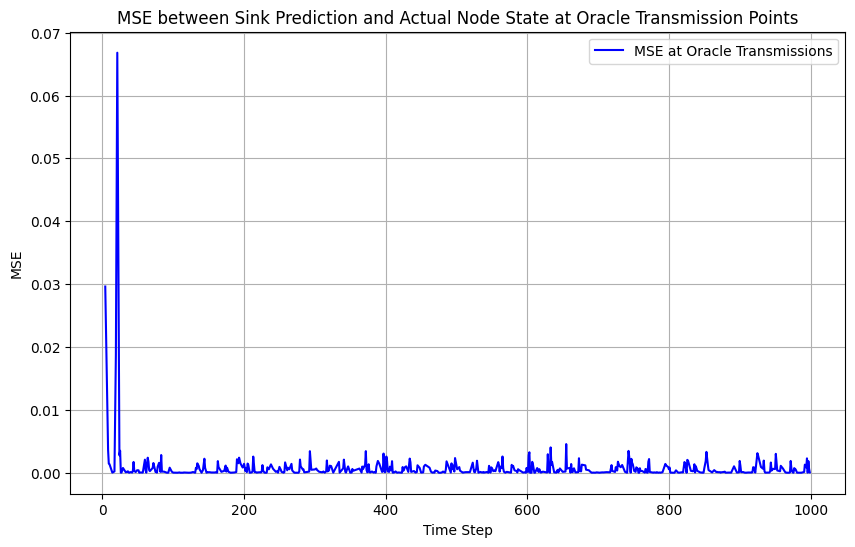

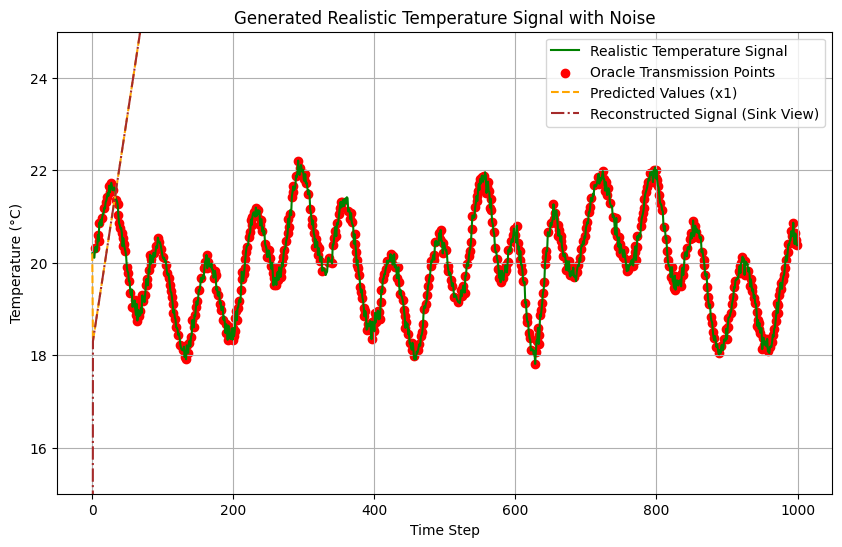

In [390]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function (between predicted and actual state)
def mse_between_estimate_and_true(predicted_value, actual_value):
    return (predicted_value - actual_value) ** 2

# Function to simulate pull-based system with Oracle VoI
def pull_based_system_with_oracle_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = z_temp[0]
    last_rate_of_change = 0.1
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []
    
    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]
    predicted_values = [z_temp[0]]  # Initialize with first value (for t=0)
    oracle_transmission_times = []  # To store transmission times
    transmitted_values = []  # Store transmitted (x1, x2)
    reconstructed_values = np.zeros(time_steps)  # Placeholder for reconstruction

    last_transmission_time = 20  # Track last transmission time
    last_transmitted_x1 = z_temp[0]  # Last transmitted point-in-time value
    last_transmitted_x2 = 0.1  # Last transmitted rate of change
    x1, x2 = update_node_state_dewma(oracle_last_transmitted_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)
    # Simulation loop for the pull-based system
    for t in range(1, time_steps):
        # Calculate delta_t as the time difference between the current time and the last update time
        delta_t = t - last_transmission_time
        
        # **Sink Predicts Node's State**
        # The sink predicts the node's state based on the last transmitted x1, x2 and the time elapsed
        predicted_value = last_transmitted_x1 + last_transmitted_x2 * delta_t
        predicted_values.append(predicted_value)

        # **Threshold Check for Sink Update**
        # The sink checks if the rate of change * delta_t exceeds the threshold, if yes, update the state
        if abs(last_transmitted_x2 * delta_t) > threshold:
            # Sink pulls the node and calculates the updated state using the dEWMA function
            measured_value = z_temp[t]
            
            
            # The sink uses the new x1, x2 for prediction
            #last_transmitted_x1 = x1
            #last_transmitted_x2 = x2

        # **Oracle Transmission Policy**: Check if the difference exceeds the threshold to trigger an update
        actual_measurement_change = abs(z_temp[t] - oracle_last_transmitted_value)
        if actual_measurement_change > threshold:
            # The oracle transmits the updated state
            # MSE Calculation (comparing the predicted value with the actual node state)
            x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)
            mse = mse_between_estimate_and_true(x1, z_temp[t])
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis
            last_state_value = x1
            last_rate_of_change = x2
            # Update oracle transmission details
            oracle_last_transmitted_value = z_temp[t]
            oracle_transmission_times.append(t)
            transmitted_values.append((t, last_transmitted_x1, last_transmitted_x2))  # Store the transmitted values

        # **Reconstruct Signal at Sink Side**
        # Reconstruct the signal at the sink side based on the transmitted values
        reconstructed_values[t] = last_transmitted_x1 + last_transmitted_x2 * (t - last_transmission_time)

        # Update the estimated state for the next iteration
        

    cumulative_mse = cumulative_mse / time_steps

    return cumulative_mse, transmission_count, voi_mse_list, predicted_values, oracle_transmission_times, transmitted_values, reconstructed_values


# Generate realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])
    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic


# Parameters for the signal
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.1  
disturbance_probability = 0  

# Generate the temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Parameters for the pull-based system
threshold = 0.1 
beta_1 = 0.9
beta_2 = 0.9
delta_t = 1  

# Run the simulation for pull-based system with Oracle VoI
cumulative_mse, transmission_count, voi_mse_list, predicted_values, oracle_transmission_times, transmitted_values, reconstructed_values = pull_based_system_with_oracle_voi(
    T_realistic, total_time, threshold, beta_1, beta_2, delta_t
)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Plot MSE over time at the oracle's transmission points
times, mse_values = zip(*voi_mse_list)
plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Sink Prediction and Actual Node State at Oracle Transmission Points")
plt.legend()
plt.grid(True)

# Plot the generated temperature signal
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Generated Realistic Temperature Signal with Noise")
#plt.xlim(5000,5500)
plt.ylim(15, 25)

# Highlight the points where the oracle transmits (pull-based system)
plt.scatter(oracle_transmission_times, np.array(T_realistic)[oracle_transmission_times], color='red', label='Oracle Transmission Points')

# Plot the predicted values (x1 from dEWMA)
plt.plot(t, predicted_values, label="Predicted Values (x1)", color='orange', linestyle='--')

# **Plot reconstructed signal at sink (pull-based system)**
plt.plot(t, reconstructed_values, label="Reconstructed Signal (Sink View)", color='brown', linestyle='-.')

plt.legend()
plt.grid(True)
plt.show()


Cumulative MSE: 32.8695702494967
Total Transmissions (Oracle): 574


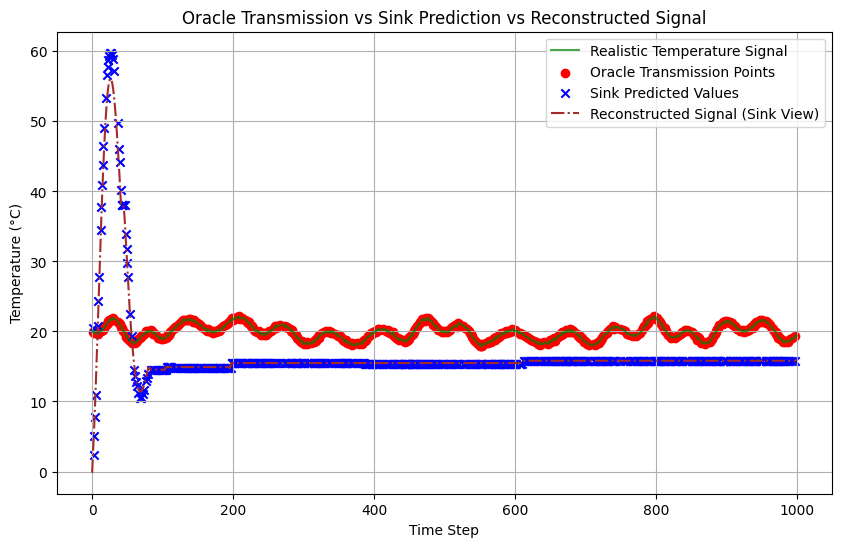

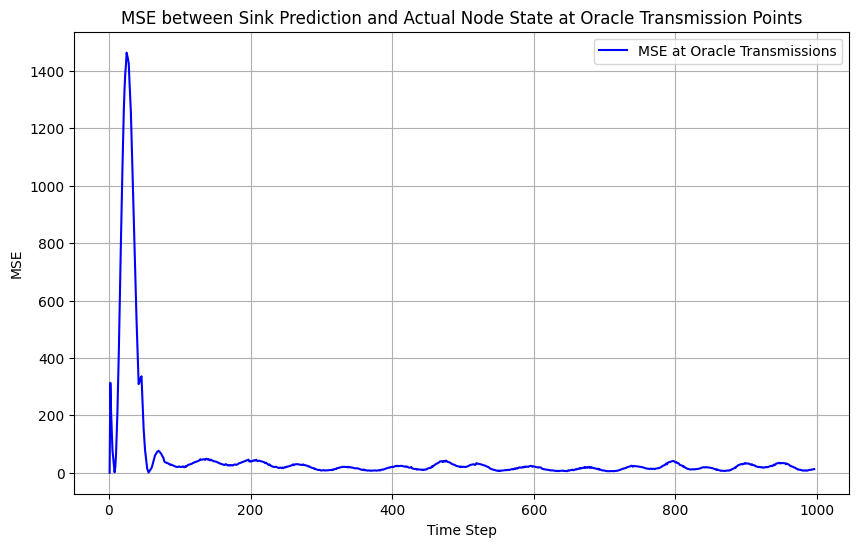

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function
def mse_between_estimate_and_true(predicted_value, actual_value):
    return (predicted_value - actual_value) ** 2

# Function to simulate pull-based system with Oracle VoI
def pull_based_system_with_oracle_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []
    
    # Initialize oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]
    oracle_transmission_times = []  # To store transmission times
    transmitted_values = []  # Store transmitted (x1, x2)
    sink_predictions = []  # Store sink's predictions at oracle update times
    reconstructed_values = np.zeros(time_steps)  # Placeholder for reconstruction

    last_transmission_time = 0
    last_transmitted_x1 = z_temp[0]  # Last transmitted point-in-time value
    last_transmitted_x2 = 0.3  # Last transmitted rate of change

    for t in range(1, time_steps):
        delta_t = t - last_transmission_time  # Time since last transmission
        
        # **Sink Predicts Node's State**
        sink_predicted_value = last_transmitted_x1 + last_transmitted_x2 * delta_t  

        # **Threshold Check for Sink Update**
        if abs(last_transmitted_x2 * delta_t) > threshold:
            measured_value = z_temp[t]
            x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)
            last_transmitted_x1 = x1
            last_transmitted_x2 = x2

        # **Oracle Transmission Policy**
        actual_measurement_change = abs(z_temp[t] - oracle_last_transmitted_value)
        if actual_measurement_change > threshold:
            # Store the sink's prediction at this oracle transmission time
            sink_predictions.append((t, sink_predicted_value))

            # MSE Calculation (comparing sink prediction with the actual measurement)
            mse = mse_between_estimate_and_true(sink_predicted_value, z_temp[t])
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))

            # Store oracle transmission and update details
            oracle_last_transmitted_value = z_temp[t]
            oracle_transmission_times.append(t)
            transmitted_values.append((t, last_transmitted_x1, last_transmitted_x2))

        # **Reconstruct Signal at Sink Side**
        reconstructed_values[t] = last_transmitted_x1 + last_transmitted_x2 * (t - last_transmission_time)

        # Update last state
        last_state_value = last_transmitted_x1
        last_rate_of_change = last_transmitted_x2

    cumulative_mse = cumulative_mse / time_steps

    return cumulative_mse, transmission_count, voi_mse_list, oracle_transmission_times, transmitted_values, reconstructed_values, sink_predictions


# Generate realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])
    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic


# Simulation Parameters
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.1  
disturbance_probability = 0  

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Pull-based system parameters
threshold = 0.1 
beta_1 = 0.1  
beta_2 = 0.1 
delta_t = 1  

# Run simulation
cumulative_mse, transmission_count, voi_mse_list, oracle_transmission_times, transmitted_values, reconstructed_values, sink_predictions = pull_based_system_with_oracle_voi(
    T_realistic, total_time, threshold, beta_1, beta_2, delta_t
)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Extract sink predictions
sink_pred_times, sink_pred_values = zip(*sink_predictions) if sink_predictions else ([], [])

# **Spline Reconstruction using x1 and x2 as gradients**
time_points, transmitted_x1_values, transmitted_x2_values = zip(*transmitted_values)

# Fit a spline to the reconstructed values at the oracle transmission points
spline = CubicSpline(time_points, transmitted_x1_values, bc_type='natural')

# Generate smooth reconstruction
smooth_reconstructed_values = spline(t)

# **Plot Results**
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green', linestyle='-', alpha=0.7)
plt.scatter(oracle_transmission_times, np.array(T_realistic)[oracle_transmission_times], color='red', label="Oracle Transmission Points")
plt.scatter(sink_pred_times, sink_pred_values, color='blue', marker='x', label="Sink Predicted Values")
plt.plot(t, smooth_reconstructed_values, label="Reconstructed Signal (Sink View)", color='brown', linestyle='-.')

plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Oracle Transmission vs Sink Prediction vs Reconstructed Signal")
plt.legend()
plt.grid(True)
plt.show()

# **Plot MSE at Oracle Transmission Points**
times, mse_values = zip(*voi_mse_list) if voi_mse_list else ([], [])

plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Sink Prediction and Actual Node State at Oracle Transmission Points")
plt.legend()
plt.grid(True)
plt.show()



Cumulative MSE: 0.6541050588695771
Total Transmissions (Oracle): 103


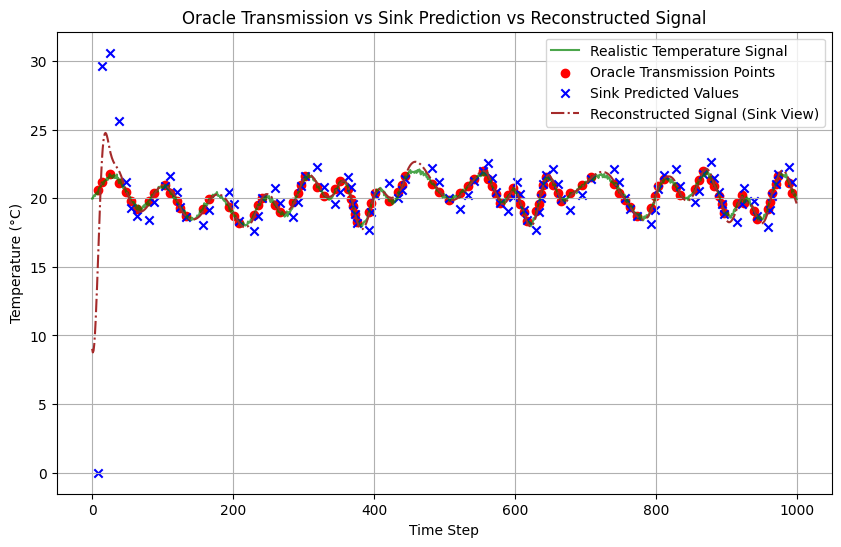

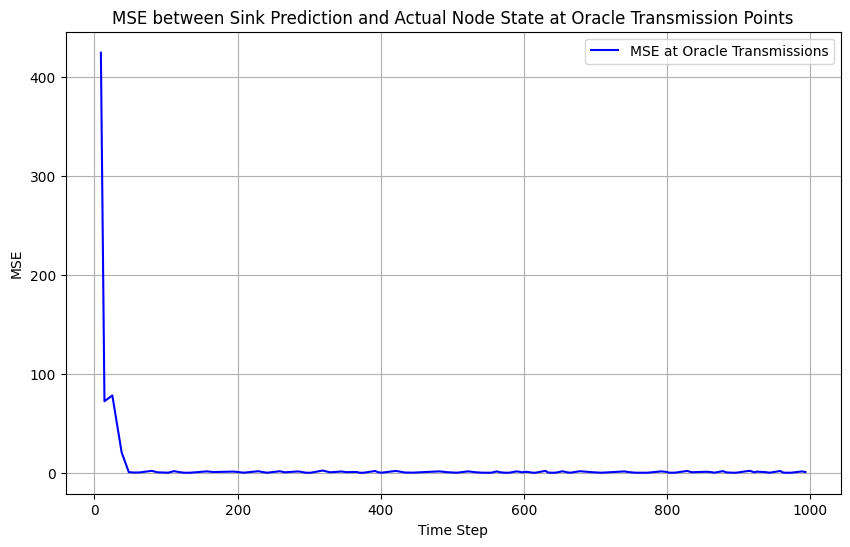

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update state using dEWMA
def update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_sink_value + last_sink_rate * delta_t)
    x2 = beta_2 * (x1 - last_sink_value) / delta_t + (1 - beta_2) * last_sink_rate
    return x1, x2

# MSE function
def mse_between_estimate_and_true(predicted_value, actual_value):
    return (predicted_value - actual_value) ** 2

# Function to simulate pull-based system with dEWMA smoothing at the sink
def pull_based_system_with_sink_dewma(z_temp, time_steps, threshold, beta_1, beta_2):
    last_node_value = 0
    last_node_rate = 0
    last_sink_value = 0
    last_sink_rate = 0
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []

    # Initialize oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]
    oracle_transmission_times = []  # To store transmission times
    transmitted_values = []  # Store transmitted (x1, x2)
    sink_predictions = []  # Store sink’s predictions
    reconstructed_values = np.zeros(time_steps)  # Placeholder for reconstruction

    for t in range(1, time_steps):
        delta_t = 1  # Now, delta_t = 1 at all times

        # **Sink Predicts Node's State**
        sink_predicted_value = last_sink_value + last_sink_rate * delta_t  

        # **Oracle Transmission Policy**: If actual change exceeds threshold, transmit
        actual_measurement_change = abs(z_temp[t] - oracle_last_transmitted_value)
        if actual_measurement_change > threshold:
            # Oracle transmits an updated value
            measured_value = z_temp[t]

            # Update the node's internal state (not sent to the sink yet)
            node_x1, node_x2 = update_sink_state_dewma(measured_value, last_node_value, last_node_rate, delta_t, beta_1, beta_2)
            last_node_value = node_x1
            last_node_rate = node_x2

            # Store the sink's prediction before the update
            sink_predictions.append((t, sink_predicted_value))

            # Update the sink’s state using dEWMA based on the new received value
            sink_x1, sink_x2 = update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2)
            last_sink_value = sink_x1
            last_sink_rate = sink_x2

            # Store the oracle transmission time and the new transmitted values
            oracle_transmission_times.append(t)
            transmitted_values.append((t, node_x1, node_x2))

            # Compute the MSE between sink prediction and actual value
            mse = mse_between_estimate_and_true(sink_predicted_value, measured_value)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))

            # Update the oracle's last transmitted value
            oracle_last_transmitted_value = measured_value

        # **Reconstruct Signal at Sink Side**
        reconstructed_values[t] = last_sink_value + last_sink_rate * delta_t

    cumulative_mse = cumulative_mse / time_steps

    return cumulative_mse, transmission_count, voi_mse_list, oracle_transmission_times, transmitted_values, reconstructed_values, sink_predictions


# Generate realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])
    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic


# Simulation Parameters
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.1  
disturbance_probability = 0  

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Pull-based system parameters
threshold = 0.5  
beta_1 = 0.8  
beta_2 = 0.8  

# Run simulation
cumulative_mse, transmission_count, voi_mse_list, oracle_transmission_times, transmitted_values, reconstructed_values, sink_predictions = pull_based_system_with_sink_dewma(
    T_realistic, total_time, threshold, beta_1, beta_2
)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Extract sink predictions
sink_pred_times, sink_pred_values = zip(*sink_predictions) if sink_predictions else ([], [])

# **Spline Reconstruction using x1 and x2 as gradients**
time_points, transmitted_x1_values, transmitted_x2_values = zip(*transmitted_values)

# Fit a spline to the reconstructed values at the oracle transmission points
spline = CubicSpline(time_points, transmitted_x1_values, bc_type='natural')

# Generate smooth reconstruction
smooth_reconstructed_values = spline(t)

# **Plot Results**
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green', linestyle='-', alpha=0.7)
plt.scatter(oracle_transmission_times, np.array(T_realistic)[oracle_transmission_times], color='red', label="Oracle Transmission Points")
plt.scatter(sink_pred_times, sink_pred_values, color='blue', marker='x', label="Sink Predicted Values")
plt.plot(t, smooth_reconstructed_values, label="Reconstructed Signal (Sink View)", color='brown', linestyle='-.')

plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Oracle Transmission vs Sink Prediction vs Reconstructed Signal")
plt.legend()
plt.grid(True)
plt.show()

# **Plot MSE at Oracle Transmission Points**
times, mse_values = zip(*voi_mse_list) if voi_mse_list else ([], [])

plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Sink Prediction and Actual Node State at Oracle Transmission Points")
plt.legend()
plt.grid(True)
plt.show()


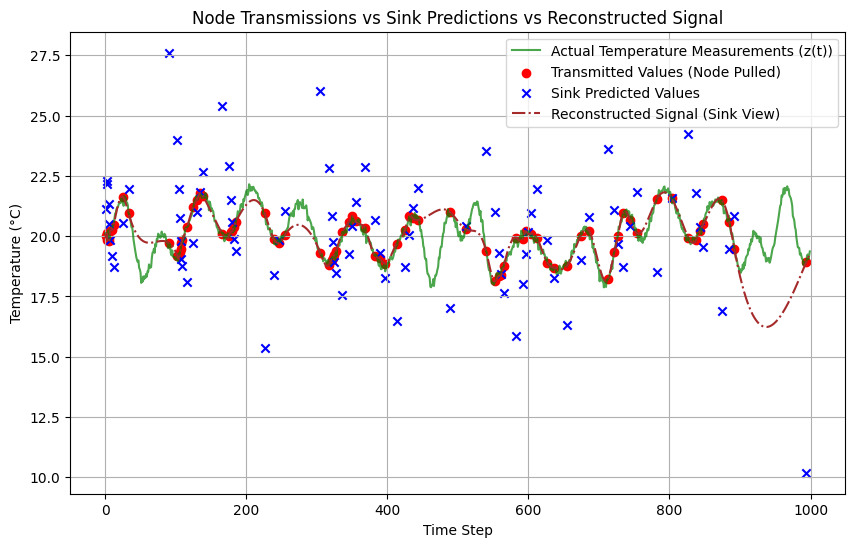

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update sink state using dEWMA
def update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_sink_value + last_sink_rate * delta_t)
    x2 = beta_2 * (x1 - last_sink_value) / delta_t + (1 - beta_2) * last_sink_rate
    return x1, x2

# Function to simulate the pull-based system (sink-side processing)
def pull_based_system_sink_dewma(z_temp, time_steps, threshold, beta_1, beta_2):
    transmission_times = []  # Time steps when the node transmits
    transmitted_values = []  # (Time, z(t))
    sink_predictions = []  # (Time, Predicted x1 at pull time)
    reconstructed_values = np.zeros(time_steps)  # Placeholder for reconstruction

    # **Initialize sink state with first measurement**
    last_sink_value = z_temp[0]  # First received measurement
    last_sink_rate = 1  # Initial rate of change is set to 1 (forces system to start updating)
    last_transmission_time = 0  # When last z(t) was received

    for t in range(1, time_steps):
        delta_t = t - last_transmission_time  # Time since last transmission

        # **Sink Predicts Node's State using x1 and x2**
        sink_predicted_value = last_sink_value + last_sink_rate * delta_t  
        
        x1, x2 = update_sink_state_dewma(sink_predicted_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2)
        last_sink_value = x1
        last_sink_rate = x2

        # **Threshold Check**: Pull the node if the predicted change exceeds the threshold
        if abs(last_sink_rate * delta_t) > threshold:
            # The sink pulls the node and receives a new measurement z(t)
            measured_value = z_temp[t]

            # **Sink updates itself using dEWMA**
            x1, x2 = update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2)

            # Store transmission times and values
            transmission_times.append(t)
            transmitted_values.append((t, measured_value))

            # Store sink's predicted value at the time of pull
            sink_predictions.append((t, sink_predicted_value))

            # Update the last received values
            last_sink_value = x1
            last_sink_rate = x2
            last_transmission_time = t  # Update transmission time

        # **Reconstruct Signal**
        reconstructed_values[t] = last_sink_value + last_sink_rate * delta_t

    return transmission_times, transmitted_values, sink_predictions, reconstructed_values

# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])
    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic

# Simulation Parameters
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.1  
disturbance_probability = 0  

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# System Parameters
threshold = 0.2  
beta_1 = 0.3
beta_2 = 0.5 

# Run the pull-based system simulation (sink-side processing)
transmission_times, transmitted_values, sink_predictions, reconstructed_values = pull_based_system_sink_dewma(
    T_realistic, total_time, threshold, beta_1, beta_2
)

# Extract values for plotting
if transmitted_values:
    transmit_times, transmit_values = zip(*transmitted_values)
else:
    transmit_times, transmit_values = [], []

if sink_predictions:
    sink_pred_times, sink_pred_values = zip(*sink_predictions)
else:
    sink_pred_times, sink_pred_values = [], []

# **Check if enough points exist for a spline fit**
if len(transmit_times) > 1:
    spline = CubicSpline(transmit_times, transmit_values, bc_type='natural')
    smooth_reconstructed_values = spline(t)
else:
    smooth_reconstructed_values = np.interp(t, transmit_times, transmit_values) if transmit_times else np.zeros_like(t)

# **Plot the Results**
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Actual Temperature Measurements (z(t))", color='green', linestyle='-', alpha=0.7)

# Highlight transmitted values
plt.scatter(transmit_times, transmit_values, color='red', label="Transmitted Values (Node Pulled)")

# Highlight sink predictions at pull times
plt.scatter(sink_pred_times, sink_pred_values, color='blue', marker='x', label="Sink Predicted Values")

# Plot reconstructed values
plt.plot(t, smooth_reconstructed_values, label="Reconstructed Signal (Sink View)", color='brown', linestyle='-.')

plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Node Transmissions vs Sink Predictions vs Reconstructed Signal")
plt.legend()
plt.grid(True)
plt.show()



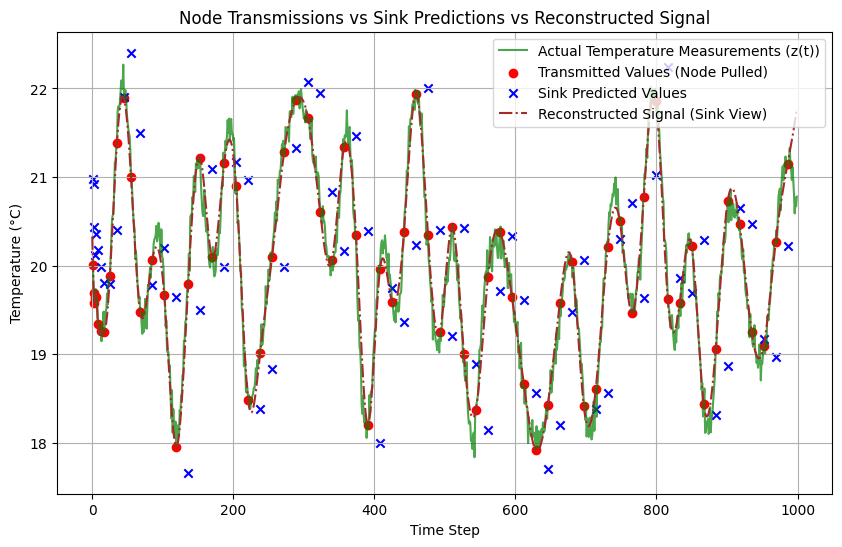

In [244]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update sink state using dEWMA
def update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_sink_value + last_sink_rate * delta_t)
    x2 = beta_2 * (x1 - last_sink_value) / delta_t + (1 - beta_2) * last_sink_rate
    return x1, x2

# Function to simulate the pull-based system (sink-side processing)
def pull_based_system_sink_dewma(z_temp, time_steps, threshold, beta_1, beta_2):
    transmission_times = []  # Time steps when the node transmits
    transmitted_values = []  # (Time, z(t))
    sink_predictions = []  # (Time, Predicted x1 at pull time)
    reconstructed_values = np.zeros(time_steps)  # Placeholder for reconstruction

    # **Initialize sink state with first measurement**
    last_sink_value = z_temp[0]  # First received measurement
    last_sink_rate = 1  # Initial rate of change is set to 1 (forces system to start updating)
    last_transmission_time = 0  # When last z(t) was received
    last_received_measurement = z_temp[0]

    for t in range(1, time_steps):
        delta_t = t - last_transmission_time  # Time since last transmission

        # **Sink Predicts Node's State using last received measurement and last sink rate**
        sink_predicted_value = last_received_measurement + last_sink_rate * delta_t  

        #x1, x2 = update_sink_state_dewma(sink_predicted_value, last_sink_value, last_sink_rate, 1, beta_1, beta_2)
        #sink_predicted_value = x1 + x2 * delta_t
        #x2 = last_sink_rate

        # **Threshold Check**: Pull the node if the predicted change exceeds the threshold
        if (abs(last_sink_rate) * delta_t > threshold) or  min_rate_of_change * delta_t > threshold:
            # The sink pulls the node and receives a new measurement z(t)
            measured_value = z_temp[t]

            # **Sink updates itself using dEWMA**
            x1, x2 = update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2)

            # Store transmission times and values
            transmission_times.append(t)
            transmitted_values.append((t, measured_value))

            # Store sink's predicted value at the time of pull
            sink_predictions.append((t, sink_predicted_value))

            # Update the last received values
            last_received_measurement = measured_value
            last_sink_value = x1
            last_sink_rate = x2
            last_transmission_time = t  # Update transmission time

        # **Reconstruct Signal**
        reconstructed_values[t] = last_sink_value + last_sink_rate * delta_t

    return transmission_times, transmitted_values, sink_predictions, reconstructed_values

# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])
    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic

# Simulation Parameters
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.1  
disturbance_probability = 0 
 

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# System Parameters
threshold = 0.5  
beta_1 = 0.3
beta_2 = 0.3
min_rate_of_change = 0.03
# Run the pull-based system simulation (sink-side processing)
transmission_times, transmitted_values, sink_predictions, reconstructed_values = pull_based_system_sink_dewma(
    T_realistic, total_time, threshold, beta_1, beta_2
)

# Extract values for plotting
if transmitted_values:
    transmit_times, transmit_values = zip(*transmitted_values)
else:
    transmit_times, transmit_values = [], []

if sink_predictions:
    sink_pred_times, sink_pred_values = zip(*sink_predictions)
else:
    sink_pred_times, sink_pred_values = [], []

# **Check if enough points exist for a spline fit**
if len(transmit_times) > 1:
    spline = CubicSpline(transmit_times, transmit_values, bc_type='natural')
    smooth_reconstructed_values = spline(t)
else:
    smooth_reconstructed_values = np.interp(t, transmit_times, transmit_values) if transmit_times else np.zeros_like(t)

# **Plot the Results**
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Actual Temperature Measurements (z(t))", color='green', linestyle='-', alpha=0.7)

# Highlight transmitted values
plt.scatter(transmit_times, transmit_values, color='red', label="Transmitted Values (Node Pulled)")

# Highlight sink predictions at pull times
plt.scatter(sink_pred_times, sink_pred_values, color='blue', marker='x', label="Sink Predicted Values")

# Plot reconstructed values
plt.plot(t, smooth_reconstructed_values, label="Reconstructed Signal (Sink View)", color='brown', linestyle='-.')

plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Node Transmissions vs Sink Predictions vs Reconstructed Signal")
plt.legend()
plt.grid(True)
plt.show()


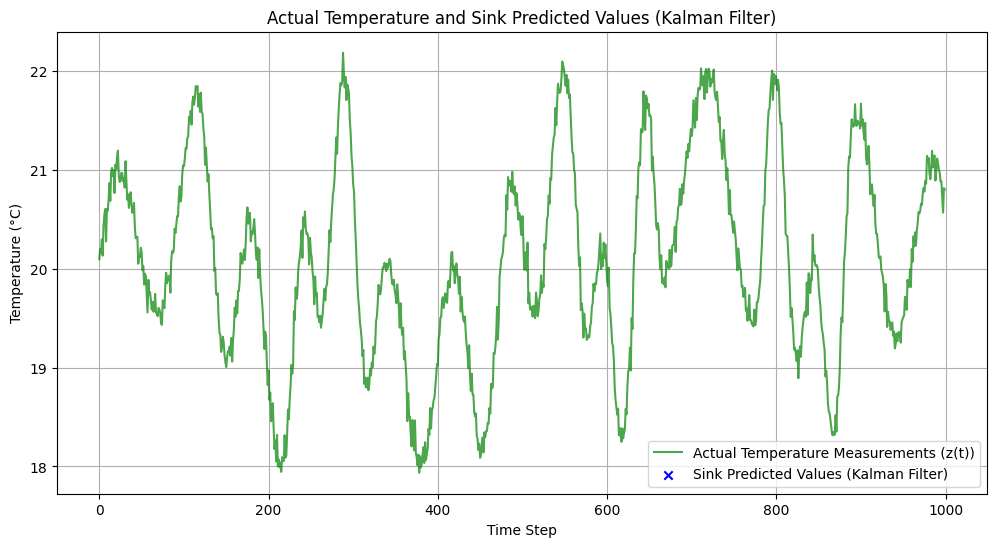

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Kalman Filter Class
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        self.A = 1  # State transition (assuming state evolves linearly)
        self.H = 1  # Measurement function (direct measurement)
        self.Q = process_variance  # Process noise covariance
        self.R = measurement_variance  # Measurement noise covariance
        self.x_hat = None  # Estimated state
        self.P = None  # Error covariance

    def initialize(self, initial_value, initial_uncertainty):
        self.x_hat = initial_value  # Initial state estimate
        self.P = initial_uncertainty  # Initial uncertainty

    def predict(self):
        """ Predict next state and update uncertainty """
        self.x_hat = self.A * self.x_hat  # Prediction step
        self.P = self.A * self.P * self.A + self.Q  # Update uncertainty

    def update(self, measurement):
        """ Update the estimate with a new measurement """
        K = self.P * self.H / (self.H * self.P * self.H + self.R)  # Kalman Gain
        self.x_hat = self.x_hat + K * (measurement - self.H * self.x_hat)  # Update estimate
        self.P = (1 - K * self.H) * self.P  # Update error covariance

    def get_rate_of_change(self):
        """ Estimate the rate of change (velocity) from predicted state """
        return self.x_hat  # The change rate could be inferred from a model of temperature change

# Function to simulate the pull-based system using Kalman Filter
def pull_based_system_sink_kalman(z_temp, time_steps, threshold, process_variance, measurement_variance):
    transmission_times = []  # Time steps when the node transmits
    transmitted_values = []  # (Time, z(t))
    sink_predictions = []  # (Time, Predicted x_hat at pull time)
    reconstructed_values = np.zeros(time_steps)  # Placeholder for reconstruction

    # Initialize Kalman filter
    kalman_filter = KalmanFilter(process_variance, measurement_variance)
    kalman_filter.initialize(z_temp[0], initial_uncertainty=1)

    last_transmission_time = 0  # Last time a measurement was received

    for t in range(1, time_steps):
        delta_t = t - last_transmission_time  # Time since last transmission

        # **Prediction Step**
        kalman_filter.predict()
        predicted_value = kalman_filter.x_hat  # Predicted state

        # **Threshold Check**: Pull the node if the predicted change exceeds the threshold
        if abs(predicted_value - kalman_filter.x_hat) > threshold:
            # The sink pulls the node and receives a new measurement z(t)
            measured_value = z_temp[t]

            # **Update the Kalman filter with the received measurement**
            kalman_filter.update(measured_value)

            # Store transmission times and values
            transmission_times.append(t)
            transmitted_values.append((t, measured_value))

            # Store sink's predicted value at the time of pull
            sink_predictions.append((t, predicted_value))

            last_transmission_time = t  # Update transmission time

    return transmission_times, transmitted_values, sink_predictions, reconstructed_values

# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])
    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic

# Simulation Parameters
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.1  
disturbance_probability = 0  

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# System Parameters
threshold = 0.1  
process_variance = 0.01  # Process noise (how much uncertainty in the system)
measurement_variance = 0.1  # Measurement noise (sensor accuracy)

# Run the pull-based system simulation (sink-side processing) using Kalman Filter
transmission_times, transmitted_values, sink_predictions, reconstructed_values = pull_based_system_sink_kalman(
    T_realistic, total_time, threshold, process_variance, measurement_variance
)

# Extract the sink predictions
if sink_predictions:
    sink_pred_times, sink_pred_values = zip(*sink_predictions)
else:
    sink_pred_times, sink_pred_values = [], []

# **Plot the Results**
plt.figure(figsize=(12, 6))

# Plot actual temperature z(t)
plt.plot(t, T_realistic, label="Actual Temperature Measurements (z(t))", color='green', linestyle='-', alpha=0.7)

# Plot sink predictions at pull times
plt.scatter(sink_pred_times, sink_pred_values, color='blue', marker='x', label="Sink Predicted Values (Kalman Filter)")

plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Actual Temperature and Sink Predicted Values (Kalman Filter)")
plt.legend()
plt.grid(True)
plt.show()



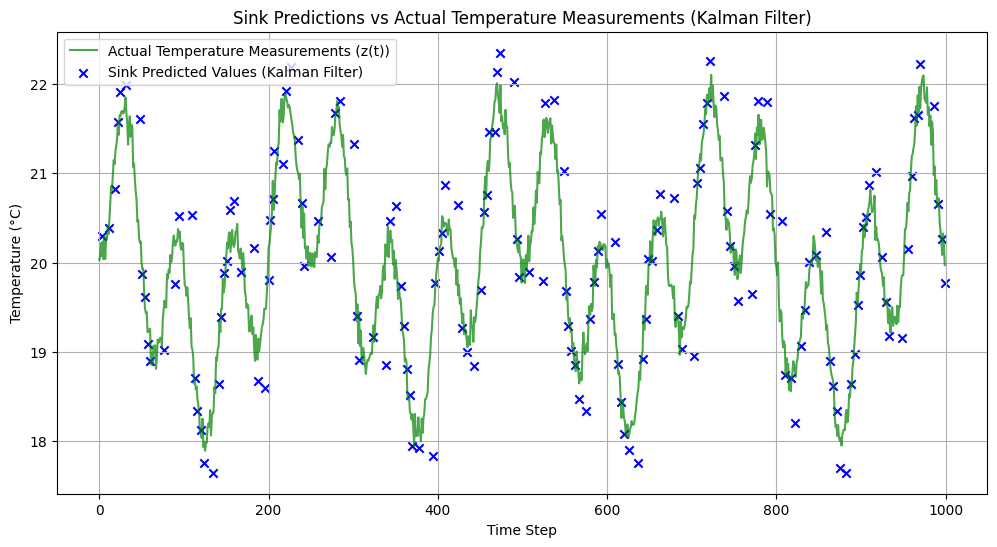

In [191]:
import numpy as np
import matplotlib.pyplot as plt

# Kalman Filter Class (Now Tracking Temperature & Rate of Change)
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        # State Transition Matrix (Tracks Temperature & Rate of Change)
        self.A = np.array([[1, 1],  # x1 (temperature) evolves by adding x2 (velocity)
                           [0, 1]]) # x2 (velocity) remains constant

        # Measurement Matrix (We only observe temperature, not velocity)
        self.H = np.array([[1, 0]])

        # Process Noise Covariance
        self.Q = np.array([[process_variance, 0],
                           [0, process_variance]])

        # Measurement Noise Covariance
        self.R = np.array([[measurement_variance]])

        # Initial State Estimate [temperature, rate of change]
        self.x_hat = np.array([20.0, 0.1])  # Start with 20°C and 0.1°C per step

        # Initial Error Covariance
        self.P = np.eye(2) * 1  # Initial uncertainty

    def predict(self):
        """ Predict next state and update uncertainty """
        self.x_hat = self.A @ self.x_hat  # State prediction
        self.P = self.A @ self.P @ self.A.T + self.Q  # Uncertainty prediction

    def update(self, measurement):
        """ Update the estimate with a new measurement """
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)  # Kalman Gain
        self.x_hat = self.x_hat + K @ (measurement - self.H @ self.x_hat)  # State update
        self.P = (np.eye(2) - K @ self.H) @ self.P  # Update error covariance

    def get_rate_of_change(self):
        """ Return the estimated rate of change (velocity) """
        return self.x_hat[1]  # x2 (velocity)


# Function to simulate the pull-based system using the improved Kalman Filter
def pull_based_system_sink_kalman(z_temp, time_steps, threshold, process_variance, measurement_variance):
    transmission_times = []  # Time steps when the node transmits
    sink_predictions = []  # (Time, Predicted x1 at pull time)

    # Initialize Kalman filter
    kalman_filter = KalmanFilter(process_variance, measurement_variance)

    last_transmission_time = 0  # Last time a measurement was received

    for t in range(1, time_steps):
        delta_t = t - last_transmission_time  # Time since last transmission

        # **Prediction Step**
        kalman_filter.predict()
        predicted_value = kalman_filter.x_hat[0]  # Predicted Temperature
        rate_of_change = kalman_filter.get_rate_of_change()  # Predicted Rate of Change

        # **Threshold Check**: Pull the node if |Rate of Change * Δt| exceeds threshold
        if (abs(rate_of_change) * delta_t > threshold) or (abs(min_rate_of_change) * delta_t > threshold):
            # The sink pulls the node and receives a new measurement z(t)
            measured_value = z_temp[t]

            # **Update the Kalman filter with the received measurement**
            kalman_filter.update(measured_value)

            # Store transmission times and predicted values at pull time
            transmission_times.append(t)
            sink_predictions.append((t, predicted_value))

            last_transmission_time = t  # Update transmission time

    return transmission_times, sink_predictions


# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude):
    t = np.arange(0, total_time, time_resolution)
    temperature_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly cycle
    omega = 2 * np.pi / T_period
    T_dynamic = temperature_variation * np.sin(omega * t) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    T_realistic = T_dynamic + noise
    return t, T_realistic


# Simulation Parameters
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.1  

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude)

# System Parameters
threshold = 0.3  # Threshold for pulling node (Rate of Change * Delta T)
process_variance = 0.1  
measurement_variance = 0.5  
min_rate_of_change = 0.02

# Run the pull-based system simulation (sink-side processing) using Kalman Filter
transmission_times, sink_predictions = pull_based_system_sink_kalman(
    T_realistic, total_time, threshold, process_variance, measurement_variance
)

# Extract values for plotting
if sink_predictions:
    sink_pred_times, sink_pred_values = zip(*sink_predictions)
else:
    sink_pred_times, sink_pred_values = [], []

# **Plot the Results**
plt.figure(figsize=(12, 6))

# Plot actual temperature z(t)
plt.plot(t, T_realistic, label="Actual Temperature Measurements (z(t))", color='green', linestyle='-', alpha=0.7)

# Plot sink predictions at pull times
plt.scatter(sink_pred_times, sink_pred_values, color='blue', marker='x', label="Sink Predicted Values (Kalman Filter)")

plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Sink Predictions vs Actual Temperature Measurements (Kalman Filter)")
plt.legend()
plt.grid(True)
plt.show()



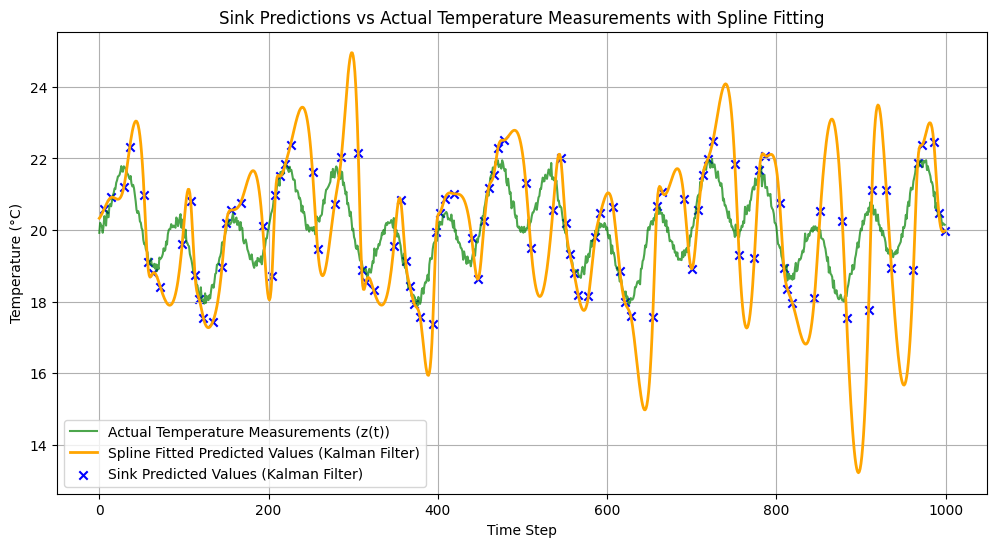

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Kalman Filter Class (Now Tracking Temperature & Rate of Change)
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        # State Transition Matrix (Tracks Temperature & Rate of Change)
        self.A = np.array([[1, 1],  # x1 (temperature) evolves by adding x2 (velocity)
                           [0, 1]]) # x2 (velocity) remains constant

        # Measurement Matrix (We only observe temperature, not velocity)
        self.H = np.array([[1, 0]])

        # Process Noise Covariance
        self.Q = np.array([[process_variance, 0],
                           [0, process_variance]])

        # Measurement Noise Covariance
        self.R = np.array([[measurement_variance]])

        # Initial State Estimate [temperature, rate of change]
        self.x_hat = np.array([20.0, 0.1])  # Start with 20°C and 0.1°C per step

        # Initial Error Covariance
        self.P = np.eye(2) * 1  # Initial uncertainty

    def predict(self):
        """ Predict next state and update uncertainty """
        self.x_hat = self.A @ self.x_hat  # State prediction
        self.P = self.A @ self.P @ self.A.T + self.Q  # Uncertainty prediction

    def update(self, measurement):
        """ Update the estimate with a new measurement """
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)  # Kalman Gain
        self.x_hat = self.x_hat + K @ (measurement - self.H @ self.x_hat)  # State update
        self.P = (np.eye(2) - K @ self.H) @ self.P  # Update error covariance

    def get_rate_of_change(self):
        """ Return the estimated rate of change (velocity) """
        return self.x_hat[1]  # x2 (velocity)


# Function to simulate the pull-based system using the improved Kalman Filter
def pull_based_system_sink_kalman(z_temp, time_steps, threshold, process_variance, measurement_variance):
    transmission_times = []  # Time steps when the node transmits
    sink_predictions = []  # (Time, Predicted x1 at pull time)

    # Initialize Kalman filter
    kalman_filter = KalmanFilter(process_variance, measurement_variance)

    last_transmission_time = 0  # Last time a measurement was received

    for t in range(1, time_steps):
        delta_t = t - last_transmission_time  # Time since last transmission

        # **Prediction Step**
        kalman_filter.predict()
        predicted_value = kalman_filter.x_hat[0]  # Predicted Temperature
        rate_of_change = kalman_filter.get_rate_of_change()  # Predicted Rate of Change

        # **Threshold Check**: Pull the node if |Rate of Change * Δt| exceeds threshold
        if (abs(rate_of_change) * delta_t > threshold) or (abs(min_rate_of_change) * delta_t > threshold):
            # The sink pulls the node and receives a new measurement z(t)
            measured_value = z_temp[t]

            # **Update the Kalman filter with the received measurement**
            kalman_filter.update(measured_value)

            # Store transmission times and predicted values at pull time
            transmission_times.append(t)
            sink_predictions.append((t, predicted_value))

            last_transmission_time = t  # Update transmission time

    return transmission_times, sink_predictions


# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude):
    t = np.arange(0, total_time, time_resolution)
    temperature_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly cycle
    omega = 2 * np.pi / T_period
    T_dynamic = temperature_variation * np.sin(omega * t) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    T_realistic = T_dynamic + noise
    return t, T_realistic


# Simulation Parameters
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.1  

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude)

# System Parameters
threshold = 0.5  # Threshold for pulling node (Rate of Change * Delta T)
process_variance = 0.001  
measurement_variance = 0.05  
min_rate_of_change = 0.02

# Run the pull-based system simulation (sink-side processing) using Kalman Filter
transmission_times, sink_predictions = pull_based_system_sink_kalman(
    T_realistic, total_time, threshold, process_variance, measurement_variance
)

# Extract values for plotting
if sink_predictions:
    sink_pred_times, sink_pred_values = zip(*sink_predictions)
else:
    sink_pred_times, sink_pred_values = [], []

# **Spline Fitting** (Cubic Spline)
spline = CubicSpline(sink_pred_times, sink_pred_values, bc_type='natural')

# Generate fitted values using spline for the full time range
spline_fitted_values = spline(t)

# **Plot the Results**
plt.figure(figsize=(12, 6))

# Plot actual temperature z(t)
plt.plot(t, T_realistic, label="Actual Temperature Measurements (z(t))", color='green', linestyle='-', alpha=0.7)

# Plot spline-fitted curve of sink predictions
plt.plot(t, spline_fitted_values, label="Spline Fitted Predicted Values (Kalman Filter)", color='orange', linestyle='-', linewidth=2)

# Plot sink predictions at pull times (marked with 'x')
plt.scatter(sink_pred_times, sink_pred_values, color='blue', marker='x', label="Sink Predicted Values (Kalman Filter)")

plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Sink Predictions vs Actual Temperature Measurements with Spline Fitting")
plt.legend()
plt.grid(True)
plt.show()


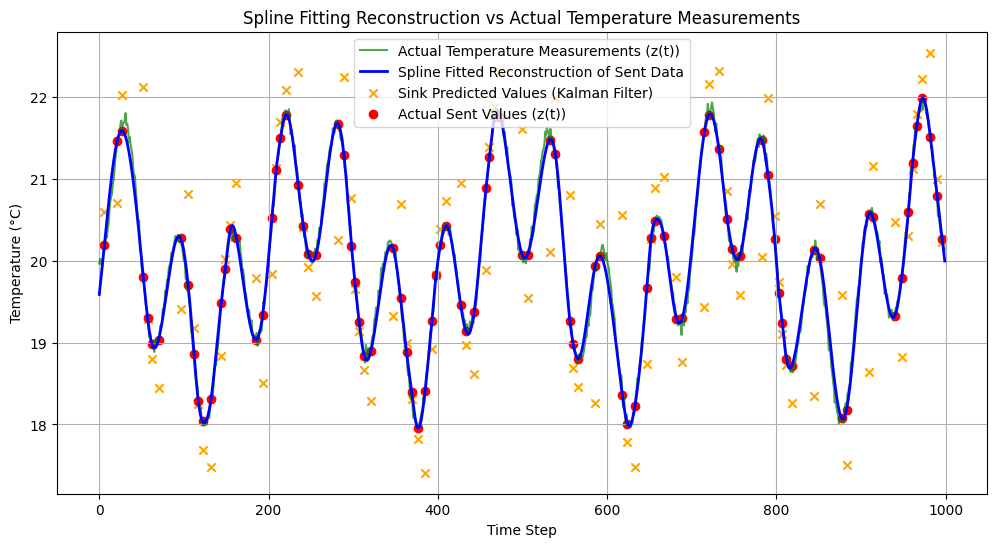

In [215]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Kalman Filter Class (Now Tracking Temperature & Rate of Change)
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        # State Transition Matrix (Tracks Temperature & Rate of Change)
        self.A = np.array([[1, 1],  # x1 (temperature) evolves by adding x2 (velocity)
                           [0, 1]]) # x2 (velocity) remains constant

        # Measurement Matrix (We only observe temperature, not velocity)
        self.H = np.array([[1, 0]])

        # Process Noise Covariance
        self.Q = np.array([[process_variance, 0],
                           [0, process_variance]])

        # Measurement Noise Covariance
        self.R = np.array([[measurement_variance]])

        # Initial State Estimate [temperature, rate of change]
        self.x_hat = np.array([20.0, 0.1])  # Start with 20°C and 0.1°C per step

        # Initial Error Covariance
        self.P = np.eye(2) * 1  # Initial uncertainty

    def predict(self):
        """ Predict next state and update uncertainty """
        self.x_hat = self.A @ self.x_hat  # State prediction
        self.P = self.A @ self.P @ self.A.T + self.Q  # Uncertainty prediction

    def update(self, measurement):
        """ Update the estimate with a new measurement """
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)  # Kalman Gain
        self.x_hat = self.x_hat + K @ (measurement - self.H @ self.x_hat)  # State update
        self.P = (np.eye(2) - K @ self.H) @ self.P  # Update error covariance

    def get_rate_of_change(self):
        """ Return the estimated rate of change (velocity) """
        return self.x_hat[1]  # x2 (velocity)


# Function to simulate the pull-based system using the improved Kalman Filter
def pull_based_system_sink_kalman(z_temp, time_steps, threshold, process_variance, measurement_variance):
    transmission_times = []  # Time steps when the node transmits
    sink_predictions = []  # (Time, Predicted x1 at pull time)
    actual_values_sent = []  # Store the actual z(t) values at transmission times
    reconstructed_values = []  # Reconstructed temperature using rate of change

    # Initialize Kalman filter
    kalman_filter = KalmanFilter(process_variance, measurement_variance)

    last_transmission_time = 0  # Last time a measurement was received
    last_predicted_temp = kalman_filter.x_hat[0]  # Initial temperature
    last_rate_of_change = kalman_filter.get_rate_of_change()  # Initial rate of change

    for t in range(1, time_steps):
        delta_t = t - last_transmission_time  # Time since last transmission

        # **Prediction Step**
        kalman_filter.predict()
        predicted_value = kalman_filter.x_hat[0]  # Predicted Temperature
        rate_of_change = kalman_filter.get_rate_of_change()  # Predicted Rate of Change

        # **Threshold Check**: Pull the node if |Rate of Change * Δt| exceeds threshold
        if (abs(rate_of_change) * delta_t > threshold) or (abs(min_rate_of_change) * delta_t > threshold):
            # The sink pulls the node and receives a new measurement z(t)
            measured_value = z_temp[t]

            # **Update the Kalman filter with the received measurement**
            kalman_filter.update(measured_value)

            # Store transmission times and predicted values at pull time
            transmission_times.append(t)
            sink_predictions.append((t, predicted_value))
            actual_values_sent.append((t, measured_value))

            # **Reconstruction** using the rate of change
            # Use the last predicted temperature and rate of change to estimate the reconstructed value
            reconstructed_temp = last_predicted_temp + last_rate_of_change * delta_t
            reconstructed_values.append((t, reconstructed_temp))

            # Update for the next loop
            last_transmission_time = t  # Update transmission time
            last_predicted_temp = predicted_value  # Update the predicted temperature
            last_rate_of_change = rate_of_change  # Update the rate of change

    return transmission_times, sink_predictions, actual_values_sent, reconstructed_values


# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude):
    t = np.arange(0, total_time, time_resolution)
    temperature_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly cycle
    omega = 2 * np.pi / T_period
    T_dynamic = temperature_variation * np.sin(omega * t) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    T_realistic = T_dynamic + noise
    return t, T_realistic


# Simulation Parameters
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.05  

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude)

# System Parameters
threshold = 0.5  # Threshold for pulling node (Rate of Change * Delta T)
process_variance = 0.01  
measurement_variance = 0.1  
min_rate_of_change = 0.02

# Run the pull-based system simulation (sink-side processing) using Kalman Filter
transmission_times, sink_predictions, actual_values_sent, reconstructed_values = pull_based_system_sink_kalman(
    T_realistic, total_time, threshold, process_variance, measurement_variance
)

# Extract values for plotting
if sink_predictions:
    sink_pred_times, sink_pred_values = zip(*sink_predictions)
else:
    sink_pred_times, sink_pred_values = [], []

if actual_values_sent:
    sent_times, sent_values = zip(*actual_values_sent)
else:
    sent_times, sent_values = [], []

if reconstructed_values:
    reconstructed_times, reconstructed_values = zip(*reconstructed_values)
else:
    reconstructed_times, reconstructed_values = [], []

# **Spline Fitting** (Cubic Spline)
spline = CubicSpline(sent_times, sent_values, bc_type='natural')

# Generate fitted values using spline for the full time range
spline_fitted_values = spline(t)

# **Plot the Results**
plt.figure(figsize=(12, 6))

# Plot actual temperature z(t)
plt.plot(t, T_realistic, label="Actual Temperature Measurements (z(t))", color='green', linestyle='-', alpha=0.7)

# Plot spline-fitted reconstruction of actual data sent to sink
plt.plot(t, spline_fitted_values, label="Spline Fitted Reconstruction of Sent Data", color='blue', linestyle='-', linewidth=2)

# Plot sink predictions at pull times (marked with 'x')
plt.scatter(sink_pred_times, sink_pred_values, color='orange', marker='x', label="Sink Predicted Values (Kalman Filter)")

# Plot actual values sent to sink
plt.scatter(sent_times, sent_values, color='red', marker='o', label="Actual Sent Values (z(t))")

plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Spline Fitting Reconstruction vs Actual Temperature Measurements")
plt.legend()
plt.grid(True)
plt.show()



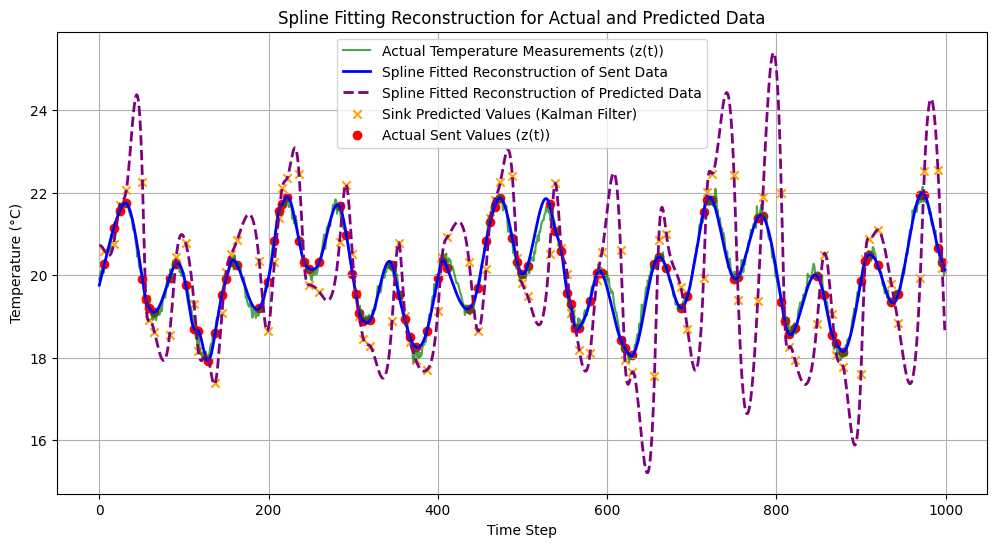

In [216]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Kalman Filter Class (Now Tracking Temperature & Rate of Change)
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        # State Transition Matrix (Tracks Temperature & Rate of Change)
        self.A = np.array([[1, 1],  # x1 (temperature) evolves by adding x2 (velocity)
                           [0, 1]]) # x2 (velocity) remains constant

        # Measurement Matrix (We only observe temperature, not velocity)
        self.H = np.array([[1, 0]])

        # Process Noise Covariance
        self.Q = np.array([[process_variance, 0],
                           [0, process_variance]])

        # Measurement Noise Covariance
        self.R = np.array([[measurement_variance]])

        # Initial State Estimate [temperature, rate of change]
        self.x_hat = np.array([20.0, 0.1])  # Start with 20°C and 0.1°C per step

        # Initial Error Covariance
        self.P = np.eye(2) * 1  # Initial uncertainty

    def predict(self):
        """ Predict next state and update uncertainty """
        self.x_hat = self.A @ self.x_hat  # State prediction
        self.P = self.A @ self.P @ self.A.T + self.Q  # Uncertainty prediction

    def update(self, measurement):
        """ Update the estimate with a new measurement """
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)  # Kalman Gain
        self.x_hat = self.x_hat + K @ (measurement - self.H @ self.x_hat)  # State update
        self.P = (np.eye(2) - K @ self.H) @ self.P  # Update error covariance

    def get_rate_of_change(self):
        """ Return the estimated rate of change (velocity) """
        return self.x_hat[1]  # x2 (velocity)


# Function to simulate the pull-based system using the improved Kalman Filter
def pull_based_system_sink_kalman(z_temp, time_steps, threshold, process_variance, measurement_variance):
    transmission_times = []  # Time steps when the node transmits
    sink_predictions = []  # (Time, Predicted x1 at pull time)
    actual_values_sent = []  # Store the actual z(t) values at transmission times
    reconstructed_values = []  # Reconstructed temperature using rate of change

    # Initialize Kalman filter
    kalman_filter = KalmanFilter(process_variance, measurement_variance)

    last_transmission_time = 0  # Last time a measurement was received
    last_predicted_temp = kalman_filter.x_hat[0]  # Initial temperature
    last_rate_of_change = kalman_filter.get_rate_of_change()  # Initial rate of change

    for t in range(1, time_steps):
        delta_t = t - last_transmission_time  # Time since last transmission
        # **Prediction Step**
        kalman_filter.predict()
        predicted_value = kalman_filter.x_hat[0]  # Predicted Temperature
        rate_of_change = kalman_filter.get_rate_of_change()  # Predicted Rate of Change

        # **Threshold Check**: Pull the node if |Rate of Change * Δt| exceeds threshold
        if (abs(rate_of_change) * delta_t > threshold) or (abs(min_rate_of_change) * delta_t > threshold):
            # The sink pulls the node and receives a new measurement z(t)
            measured_value = z_temp[t]

            # **Update the Kalman filter with the received measurement**
            kalman_filter.update(measured_value)

            # Store transmission times and predicted values at pull time
            transmission_times.append(t)
            sink_predictions.append((t, predicted_value))
            actual_values_sent.append((t, measured_value))

            # **Reconstruction** using the rate of change
            # Use the last predicted temperature and rate of change to estimate the reconstructed value
            reconstructed_temp = last_predicted_temp + last_rate_of_change * delta_t
            reconstructed_values.append((t, reconstructed_temp))

            # Update for the next loop
            last_transmission_time = t  # Update transmission time
            last_predicted_temp = predicted_value  # Update the predicted temperature
            last_rate_of_change = rate_of_change  # Update the rate of change

    return transmission_times, sink_predictions, actual_values_sent, reconstructed_values


# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude):
    t = np.arange(0, total_time, time_resolution)
    temperature_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly cycle
    omega = 2 * np.pi / T_period
    T_dynamic = temperature_variation * np.sin(omega * t) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    T_realistic = T_dynamic + noise
    return t, T_realistic


# Simulation Parameters
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.1  

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude)

# System Parameters
threshold = 0.5  # Threshold for pulling node (Rate of Change * Delta T)
process_variance = 0.001  
measurement_variance = 0.05  
min_rate_of_change = 0.02

# Run the pull-based system simulation (sink-side processing) using Kalman Filter
transmission_times, sink_predictions, actual_values_sent, reconstructed_values = pull_based_system_sink_kalman(
    T_realistic, total_time, threshold, process_variance, measurement_variance
)

# Extract values for plotting
if sink_predictions:
    sink_pred_times, sink_pred_values = zip(*sink_predictions)
else:
    sink_pred_times, sink_pred_values = [], []

if actual_values_sent:
    sent_times, sent_values = zip(*actual_values_sent)
else:
    sent_times, sent_values = [], []

if reconstructed_values:
    reconstructed_times, reconstructed_values = zip(*reconstructed_values)
else:
    reconstructed_times, reconstructed_values = [], []

# **Spline Fitting for Actual Data Sent to Sink**
spline_sent = CubicSpline(sent_times, sent_values, bc_type='natural')
spline_sent_fitted_values = spline_sent(t)

# **Spline Fitting for Predicted Values from Kalman Filter**
spline_pred = CubicSpline(sink_pred_times, sink_pred_values, bc_type='natural')
spline_pred_fitted_values = spline_pred(t)

# **Plot the Results**
plt.figure(figsize=(12, 6))

# Plot actual temperature z(t)
plt.plot(t, T_realistic, label="Actual Temperature Measurements (z(t))", color='green', linestyle='-', alpha=0.7)

# Plot spline-fitted reconstruction of actual data sent to sink
plt.plot(t, spline_sent_fitted_values, label="Spline Fitted Reconstruction of Sent Data", color='blue', linestyle='-', linewidth=2)

# Plot spline-fitted reconstruction of predicted values from Kalman filter
plt.plot(t, spline_pred_fitted_values, label="Spline Fitted Reconstruction of Predicted Data", color='purple', linestyle='--', linewidth=2)

# Plot sink predictions at pull times (marked with 'x')
plt.scatter(sink_pred_times, sink_pred_values, color='orange', marker='x', label="Sink Predicted Values (Kalman Filter)")

# Plot actual values sent to sink
plt.scatter(sent_times, sent_values, color='red', marker='o', label="Actual Sent Values (z(t))")

plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Spline Fitting Reconstruction for Actual and Predicted Data")
plt.legend()
plt.grid(True)
plt.show()


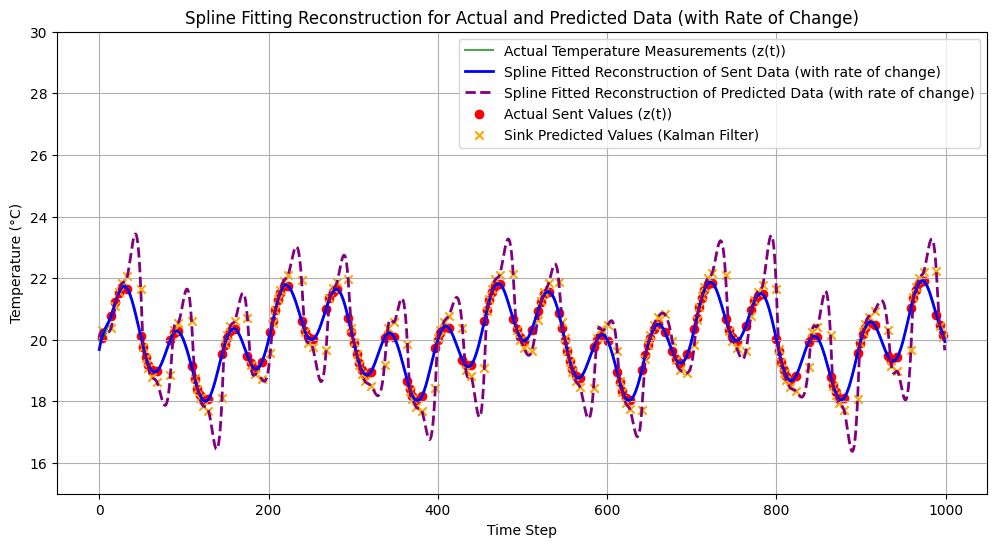

In [254]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Kalman Filter Class (Now Tracking Temperature & Rate of Change)
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        # State Transition Matrix (Tracks Temperature & Rate of Change)
        self.A = np.array([[1, 1],  # x1 (temperature) evolves by adding x2 (velocity)
                           [0, 1]]) # x2 (velocity) remains constant

        # Measurement Matrix (We only observe temperature, not velocity)
        self.H = np.array([[1, 0]])

        # Process Noise Covariance
        self.Q = np.array([[process_variance, 0],
                           [0, process_variance]])

        # Measurement Noise Covariance
        self.R = np.array([[measurement_variance]])

        # Initial State Estimate [temperature, rate of change]
        self.x_hat = np.array([20.0, 0.1])  # Start with 20°C and 0.1°C per step

        # Initial Error Covariance
        self.P = np.eye(2) * 1  # Initial uncertainty

    def predict(self):
        """ Predict next state and update uncertainty """
        self.x_hat = self.A @ self.x_hat  # State prediction
        self.P = self.A @ self.P @ self.A.T + self.Q  # Uncertainty prediction

    def update(self, measurement):
        """ Update the estimate with a new measurement """
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)  # Kalman Gain
        self.x_hat = self.x_hat + K @ (measurement - self.H @ self.x_hat)  # State update
        self.P = (np.eye(2) - K @ self.H) @ self.P  # Update error covariance

    def get_rate_of_change(self):
        """ Return the estimated rate of change (velocity) """
        return self.x_hat[1]  # x2 (velocity)


# Function to simulate the pull-based system using the improved Kalman Filter
def pull_based_system_sink_kalman(z_temp, time_steps, threshold, process_variance, measurement_variance):
    transmission_times = []  # Time steps when the node transmits
    sink_predictions = []  # (Time, Predicted x1 at pull time)
    actual_values_sent = []  # Store the actual z(t) values at transmission times
    reconstructed_values = []  # Reconstructed temperature using rate of change
    rate_of_change_at_sent_times = []  # Store rate of change at sent times
    rate_of_change_at_pred_times = []  # Store rate of change at predicted times

    # Initialize Kalman filter
    kalman_filter = KalmanFilter(process_variance, measurement_variance)

    last_transmission_time = 0  # Last time a measurement was received
    last_predicted_temp = kalman_filter.x_hat[0]  # Initial temperature
    last_rate_of_change = kalman_filter.get_rate_of_change()  # Initial rate of change

    for t in range(1, time_steps):
        delta_t = t - last_transmission_time  # Time since last transmission

        # **Prediction Step**
        kalman_filter.predict()
        predicted_value = kalman_filter.x_hat[0]  # Predicted Temperature
        rate_of_change = kalman_filter.get_rate_of_change()  # Predicted Rate of Change

        # **Threshold Check**: Pull the node if |Rate of Change * Δt| exceeds threshold
        if (abs(rate_of_change) * delta_t > threshold) or (abs(min_rate_of_change) * delta_t > threshold):
            # The sink pulls the node and receives a new measurement z(t)
            measured_value = z_temp[t]

            # **Update the Kalman filter with the received measurement**
            kalman_filter.update(measured_value)

            # Store transmission times, predictions, and rate of change values at pull time
            transmission_times.append(t)
            sink_predictions.append((t, predicted_value))
            actual_values_sent.append((t, measured_value))
            rate_of_change_at_sent_times.append(rate_of_change)  # Save rate of change at pull time
            rate_of_change_at_pred_times.append(kalman_filter.get_rate_of_change())  # Save predicted rate of change

            # **Reconstruction** using the rate of change
            reconstructed_temp = last_predicted_temp + last_rate_of_change * delta_t
            reconstructed_values.append((t, reconstructed_temp))

            # Update for the next loop
            last_transmission_time = t  # Update transmission time
            last_predicted_temp = predicted_value  # Update the predicted temperature
            last_rate_of_change = rate_of_change  # Update the rate of change

    return transmission_times, sink_predictions, actual_values_sent, reconstructed_values, rate_of_change_at_sent_times, rate_of_change_at_pred_times


# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude):
    t = np.arange(0, total_time, time_resolution)
    temperature_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly cycle
    omega = 2 * np.pi / T_period
    T_dynamic = temperature_variation * np.sin(omega * t) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    T_realistic = T_dynamic + noise
    return t, T_realistic


# Simulation Parameters
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.01  

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude)

# System Parameters
threshold = 0.3  # Threshold for pulling node (Rate of Change * Delta T)
process_variance = 0.01  
measurement_variance = 0.2 
min_rate_of_change = 0.02

# Run the pull-based system simulation (sink-side processing) using Kalman Filter
transmission_times, sink_predictions, actual_values_sent, reconstructed_values, rate_of_change_at_sent_times, rate_of_change_at_pred_times = pull_based_system_sink_kalman(
    T_realistic, total_time, threshold, process_variance, measurement_variance
)

# **Spline Fitting for Actual Data Sent to Sink with Derivative Constraints**
spline_sent = CubicSpline(transmission_times, [v[1] for v in actual_values_sent], bc_type=((1, rate_of_change_at_sent_times[0]), (1, rate_of_change_at_sent_times[-1])))
spline_sent_fitted_values = spline_sent(t)

# **Spline Fitting for Predicted Values from Kalman Filter with Derivative Constraints**
spline_pred = CubicSpline(transmission_times, [v[1] for v in sink_predictions], bc_type=((1, rate_of_change_at_pred_times[0]), (1, rate_of_change_at_pred_times[-1])))
spline_pred_fitted_values = spline_pred(t)

# **Plot the Results**
plt.figure(figsize=(12, 6))

# Plot actual temperature z(t)
plt.plot(t, T_realistic, label="Actual Temperature Measurements (z(t))", color='green', linestyle='-', alpha=0.7)

# Plot spline-fitted reconstruction of actual data sent to sink with derivative constraints
plt.plot(t, spline_sent_fitted_values, label="Spline Fitted Reconstruction of Sent Data (with rate of change)", color='blue', linestyle='-', linewidth=2)

# Plot spline-fitted reconstruction of predicted values from Kalman filter with derivative constraints
plt.plot(t, spline_pred_fitted_values, label="Spline Fitted Reconstruction of Predicted Data (with rate of change)", color='purple', linestyle='--', linewidth=2)

# Plot actual values sent to sink
plt.scatter([v[0] for v in actual_values_sent], [v[1] for v in actual_values_sent], color='red', marker='o', label="Actual Sent Values (z(t))")

# Plot sink predictions at pull times (marked with 'x')
plt.scatter([v[0] for v in sink_predictions], [v[1] for v in sink_predictions], color='orange', marker='x', label="Sink Predicted Values (Kalman Filter)")

plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Spline Fitting Reconstruction for Actual and Predicted Data (with Rate of Change)")
plt.legend()
plt.ylim(15,30)
plt.grid(True)
plt.show()


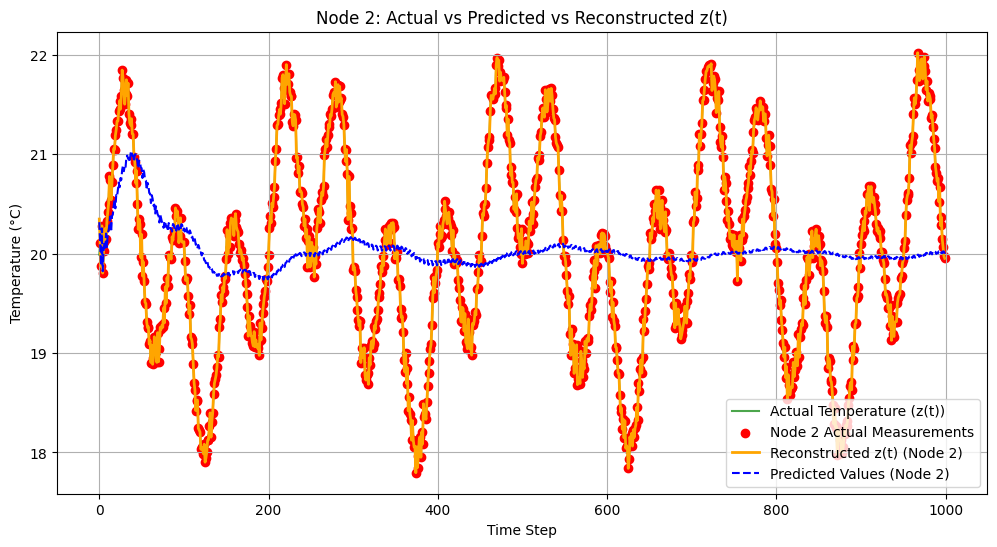

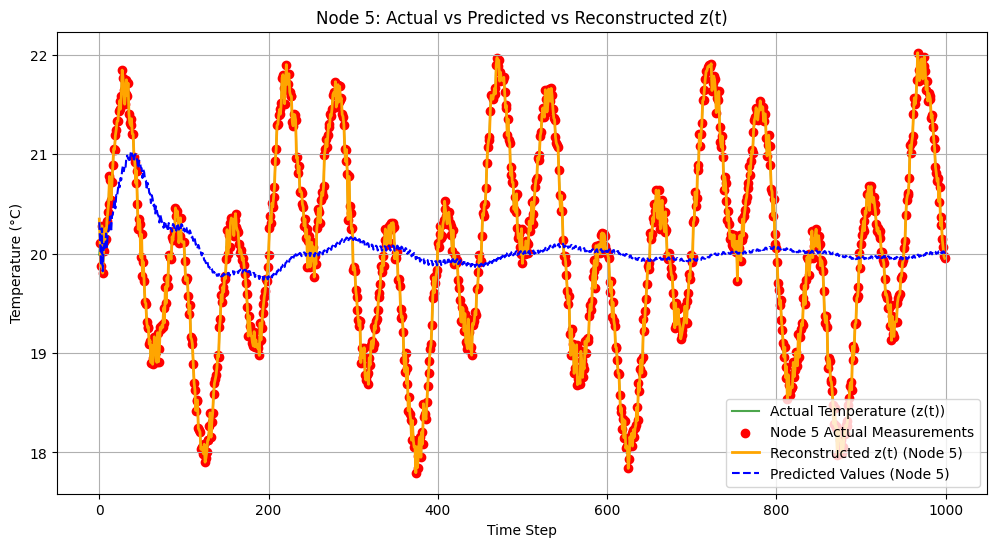

In [261]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Kalman Filter Class
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        self.A = np.array([[1, 1],  # x1 (temperature) evolves by adding x2 (velocity)
                           [0, 1]]) # x2 (velocity) remains constant

        self.H = np.array([[1, 0]])

        self.Q = np.array([[process_variance, 0],
                           [0, process_variance]])

        self.R = np.array([[measurement_variance]])

        self.x_hat = np.array([20.0, 0.5])  # Start with 20°C and 0.1°C per step

        self.P = np.eye(2) * 1  # Initial uncertainty

    def predict(self):
        """ Predict next state and update uncertainty """
        self.x_hat = self.A @ self.x_hat  # State prediction
        self.P = self.A @ self.P @ self.A.T + self.Q  # Uncertainty prediction

    def update(self, measurement):
        """ Update the estimate with a new measurement """
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)  # Kalman Gain
        self.x_hat = self.x_hat + K @ (measurement - self.H @ self.x_hat)  # State update
        self.P = (np.eye(2) - K @ self.H) @ self.P  # Update error covariance

    def get_rate_of_change(self):
        """ Return the estimated rate of change (velocity) """
        return self.x_hat[1]  # x2 (velocity)


# Function to simulate the pull-based system with 10 nodes and the sink pulling 2 nodes at a time
def multi_node_pull_based_system(z_temp, time_steps, threshold, process_variance, measurement_variance):
    # Initialize Kalman filters for 10 nodes
    num_nodes = 10
    kalman_filters = {i: KalmanFilter(process_variance, measurement_variance) for i in range(1, num_nodes + 1)}
    
    # Last update time for each node
    last_update_times = {i: 0 for i in range(1, num_nodes + 1)}

    # Tracking variables for sink predictions and actual measurements
    transmission_times = []  # Time steps when the node transmits
    sink_predictions = []  # (Time, Predicted x1 at pull time)
    sent_times = []  # Times when actual measurements (z(t)) are sent
    sent_values = []  # Actual z(t) values when sent

    # Loop over each time step
    for t in range(1, time_steps):
        # Evaluate which nodes to pull
        node_scores = {}
        
        # Calculate the product of (rate of change * delta_t) for each node
        for node_id in range(1, num_nodes + 1):
            delta_t = t - last_update_times[node_id]  # Time since last update
            rate_of_change = kalman_filters[node_id].get_rate_of_change()  # Get rate of change for node
            
            product = abs(rate_of_change) * delta_t  # The product to evaluate the node for pulling
            node_scores[node_id] = product
        
        # Sort the nodes based on the product and select the top 2
        selected_nodes = sorted(node_scores, key=node_scores.get, reverse=True)[:2]

        # Pull the selected nodes
        for node_id in selected_nodes:
            # The sink pulls the node and receives a new measurement z(t)
            measured_value = z_temp[t]

            # Update the Kalman filter with the received measurement
            kalman_filters[node_id].update(measured_value)

            # Store the prediction time and predicted value at the pull time
            transmission_times.append(t)
            sink_predictions.append((t, kalman_filters[node_id].x_hat[0]))

            # Store the actual z(t) value for the node pulled
            sent_times.append(t)
            sent_values.append(measured_value)

            # Update the last pulled time for the node
            last_update_times[node_id] = t

    return transmission_times, sink_predictions, sent_times, sent_values


# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude):
    t = np.arange(0, total_time, time_resolution)
    temperature_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly cycle
    omega = 2 * np.pi / T_period
    T_dynamic = temperature_variation * np.sin(omega * t) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    T_realistic = T_dynamic + noise
    return t, T_realistic


# Simulation Parameters
total_time = 1000  
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.1  

t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude)

# System Parameters
threshold = 0.3  # Threshold for pulling node (Rate of Change * Delta T)
process_variance = 0.01  
measurement_variance = 0.1  

# Run the multi-node pull-based system simulation (sink-side processing) using Kalman Filter
transmission_times, sink_predictions, sent_times, sent_values = multi_node_pull_based_system(
    T_realistic, total_time, threshold, process_variance, measurement_variance
)

# **Extract data for Node 2 and Node 5**
node_ids = [2, 5]
node_data = {}
for node_id in node_ids:
    node_data[node_id] = {
        'sent_times': [],
        'sent_values': [],
        'sink_pred_times': [],
        'sink_pred_values': []
    }
    
    for i, t in enumerate(sent_times):
        if t in transmission_times:
            node_data[node_id]['sent_times'].append(sent_times[i])
            node_data[node_id]['sent_values'].append(sent_values[i])

    # Store the predicted values for each node
    for i, t in enumerate(transmission_times):
        if t in node_data[node_id]['sent_times']:
            node_data[node_id]['sink_pred_times'].append(t)
            node_data[node_id]['sink_pred_values'].append(sink_predictions[i][1])

# Generate the correct time steps for the plot
t = np.arange(0, total_time, time_resolution)

# **Plot the Results for Node 2 and Node 5**
for node_id in node_ids:
    # Ensure sent_times and sent_values are sorted
    sorted_indices = np.argsort(node_data[node_id]['sent_times'])
    sorted_sent_times = np.array(node_data[node_id]['sent_times'])[sorted_indices]
    sorted_sent_values = np.array(node_data[node_id]['sent_values'])[sorted_indices]
    
    # Remove duplicates if there are any
    unique_sent_times, unique_indices = np.unique(sorted_sent_times, return_index=True)
    unique_sent_values = sorted_sent_values[unique_indices]
    
    # Spline fitting for the actual sent values (z(t))
    spline_sent = CubicSpline(unique_sent_times, unique_sent_values, bc_type='natural')
    spline_sent_fitted_values = spline_sent(t)

    # Spline fitting for the predicted values (Kalman Filter)
    sorted_pred_indices = np.argsort(node_data[node_id]['sink_pred_times'])
    sorted_pred_times = np.array(node_data[node_id]['sink_pred_times'])[sorted_pred_indices]
    sorted_pred_values = np.array(node_data[node_id]['sink_pred_values'])[sorted_pred_indices]
    
    # Remove duplicates if there are any
    unique_pred_times, unique_pred_indices = np.unique(sorted_pred_times, return_index=True)
    unique_pred_values = sorted_pred_values[unique_pred_indices]
    
    # Spline fitting for the predicted values (Kalman Filter)
    spline_pred = CubicSpline(unique_pred_times, unique_pred_values, bc_type='natural')
    spline_pred_fitted_values = spline_pred(t)

    # **Plot the Results for Node 2 and Node 5**
    plt.figure(figsize=(12, 6))
    plt.plot(t, T_realistic, label="Actual Temperature (z(t))", color='green', linestyle='-', alpha=0.7)
    plt.scatter(unique_sent_times, unique_sent_values, color='red', marker='o', label=f"Node {node_id} Actual Measurements")

    plt.plot(t, spline_sent_fitted_values, label=f"Reconstructed z(t) (Node {node_id})", color='orange', linestyle='-', linewidth=2)
    plt.plot(t, spline_pred_fitted_values, label=f"Predicted Values (Node {node_id})", color='blue', linestyle='--')

    plt.xlabel("Time Step")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Node {node_id}: Actual vs Predicted vs Reconstructed z(t)")
    plt.legend()
    plt.grid(True)
    plt.show()




Shape of t: (1000,), Shape of T_realistic: (1000,)


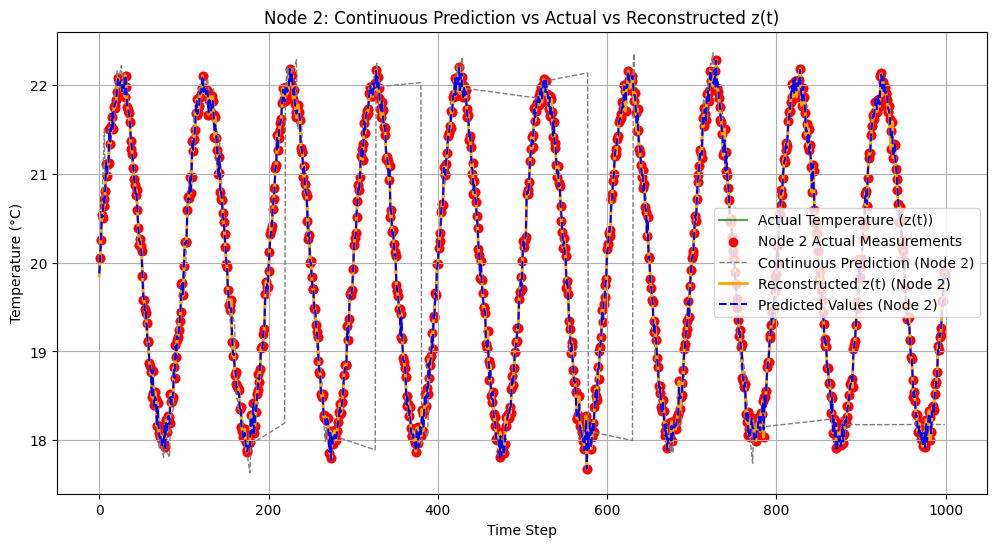

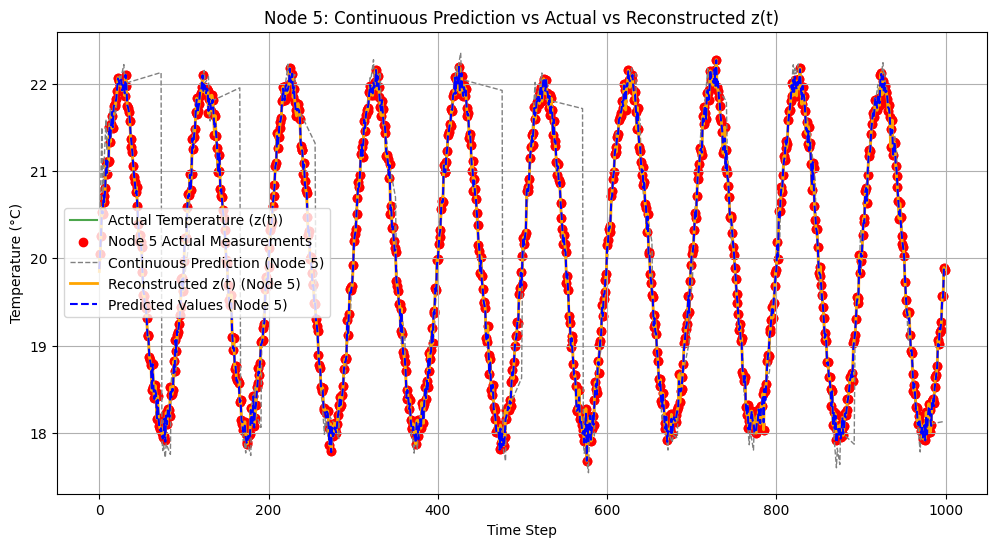

In [264]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Kalman Filter Class
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        self.A = np.array([[1, 1],  # x1 (temperature) evolves by adding x2 (velocity)
                           [0, 1]]) # x2 (velocity) remains constant

        self.H = np.array([[1, 0]])

        self.Q = np.array([[process_variance, 0],
                           [0, process_variance]])

        self.R = np.array([[measurement_variance]])

        self.x_hat = np.array([20.0, 0.5])  # Start with 20°C and 0.1°C per step

        self.P = np.eye(2) * 1  # Initial uncertainty

    def predict(self):
        """ Predict next state and update uncertainty """
        self.x_hat = self.A @ self.x_hat  # State prediction
        self.P = self.A @ self.P @ self.A.T + self.Q  # Uncertainty prediction

    def update(self, measurement):
        """ Update the estimate with a new measurement """
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)  # Kalman Gain
        self.x_hat = self.x_hat + K @ (measurement - self.H @ self.x_hat)  # State update
        self.P = (np.eye(2) - K @ self.H) @ self.P  # Update error covariance

    def get_rate_of_change(self):
        """ Return the estimated rate of change (velocity) """
        return self.x_hat[1]  # x2 (velocity)


# Function to simulate the pull-based system with 10 nodes and continuous prediction
def multi_node_pull_based_system(z_temp, time_steps, threshold, process_variance, measurement_variance):
    num_nodes = 10
    kalman_filters = {i: KalmanFilter(process_variance, measurement_variance) for i in range(1, num_nodes + 1)}
    last_update_times = {i: 0 for i in range(1, num_nodes + 1)}

    transmission_times = []  # When the node transmits
    sink_predictions = []  # Predicted x1 at pull time
    sent_times = []  # When actual measurements (z(t)) are sent
    sent_values = []  # Actual z(t) values when sent
    continuous_predictions = {i: [] for i in range(1, num_nodes + 1)}  # Continuous predictions at each time step

    for t in range(1, time_steps):
        node_scores = {}
        
        for node_id in range(1, num_nodes + 1):
            # **Continuous Prediction Step** (Predict for all nodes at every timestep)
            kalman_filters[node_id].predict()
            predicted_value = kalman_filters[node_id].x_hat[0]  # Predicted Temperature
            rate_of_change = kalman_filters[node_id].get_rate_of_change()  # Predicted Rate of Change
            
            # Store continuous predictions for plotting later
            continuous_predictions[node_id].append((t, predicted_value))

            # Calculate the pull score (rate_of_change * delta_t)
            delta_t = t - last_update_times[node_id]
            product = abs(rate_of_change) * delta_t
            node_scores[node_id] = product
        
        # **Pull the top 2 nodes with the highest scores**
        selected_nodes = sorted(node_scores, key=node_scores.get, reverse=True)[:2]

        for node_id in selected_nodes:
            measured_value = z_temp[t]  # Simulated real measurement
            kalman_filters[node_id].update(measured_value)  # Update with real data

            # Store transmission times and values
            transmission_times.append(t)
            sink_predictions.append((t, kalman_filters[node_id].x_hat[0]))
            sent_times.append(t)
            sent_values.append(measured_value)

            # Update last pulled time
            last_update_times[node_id] = t

    return transmission_times, sink_predictions, sent_times, sent_values, continuous_predictions


# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude):
    t = np.arange(0, total_time, time_resolution)
    omega = 2 * np.pi / T_period
    T_dynamic = 2 * np.sin(omega * t) + T_avg  # Dynamic temperature variation
    noise = np.random.normal(0, noise_amplitude, len(t))
    return t, T_dynamic + noise




# Generate the correct time steps based on the total simulation time and resolution
time_resolution = 1  # Ensure this is consistent with the rest of the code
total_time = 1000  # Adjust based on your simulation

# Ensure `t` has the correct shape
t = np.arange(0, total_time, time_resolution)

# Verify shapes before plotting
print(f"Shape of t: {t.shape}, Shape of T_realistic: {T_realistic.shape}")

# **Plot the Results for Only Node 2 and Node 5**
node_ids = [2, 5]  # We are only interested in these nodes

for node_id in node_ids:
    plt.figure(figsize=(12, 6))
    
    # Ensure plotting arrays have correct dimensions
    plt.plot(t, T_realistic[:len(t)], label="Actual Temperature (z(t))", color='green', linestyle='-', alpha=0.7)

    plt.scatter(node_data[node_id]['sent_times'], node_data[node_id]['sent_values'], color='red', marker='o', label=f"Node {node_id} Actual Measurements")
    plt.plot(node_data[node_id]['continuous_times'], node_data[node_id]['continuous_values'], label=f"Continuous Prediction (Node {node_id})", color='gray', linestyle='--', linewidth=1)

    # **Ensure sent_times and sent_values are sorted & strictly increasing**
    sorted_indices = np.argsort(node_data[node_id]['sent_times'])
    sorted_sent_times = np.array(node_data[node_id]['sent_times'])[sorted_indices]
    sorted_sent_values = np.array(node_data[node_id]['sent_values'])[sorted_indices]

    # Remove duplicates if any
    unique_sent_times, unique_indices = np.unique(sorted_sent_times, return_index=True)
    unique_sent_values = sorted_sent_values[unique_indices]

    if len(unique_sent_times) > 1:  # Ensure there are enough points for interpolation
        spline_sent = CubicSpline(unique_sent_times, unique_sent_values, bc_type='natural')
        spline_sent_fitted_values = spline_sent(t)  # Use full time range t
        plt.plot(t, spline_sent_fitted_values, label=f"Reconstructed z(t) (Node {node_id})", color='orange', linestyle='-', linewidth=2)
    else:
        print(f"Skipping spline fit for Node {node_id} - Not enough unique time points.")

    # **Ensure sink_pred_times and sink_pred_values are sorted & strictly increasing**
    sorted_pred_indices = np.argsort(node_data[node_id]['sink_pred_times'])
    sorted_pred_times = np.array(node_data[node_id]['sink_pred_times'])[sorted_pred_indices]
    sorted_pred_values = np.array(node_data[node_id]['sink_pred_values'])[sorted_pred_indices]

    # Remove duplicates if any
    unique_pred_times, unique_pred_indices = np.unique(sorted_pred_times, return_index=True)
    unique_pred_values = sorted_pred_values[unique_pred_indices]

    if len(unique_pred_times) > 1:  # Ensure enough points for interpolation
        spline_pred = CubicSpline(unique_pred_times, unique_pred_values, bc_type='natural')
        spline_pred_fitted_values = spline_pred(t)  # Use full time range t
        plt.plot(t, spline_pred_fitted_values, label=f"Predicted Values (Node {node_id})", color='blue', linestyle='--')
    else:
        print(f"Skipping spline fit for Node {node_id} - Not enough unique time points.")

    plt.xlabel("Time Step")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Node {node_id}: Continuous Prediction vs Actual vs Reconstructed z(t)")
    plt.legend()
    plt.grid(True)
    plt.show()



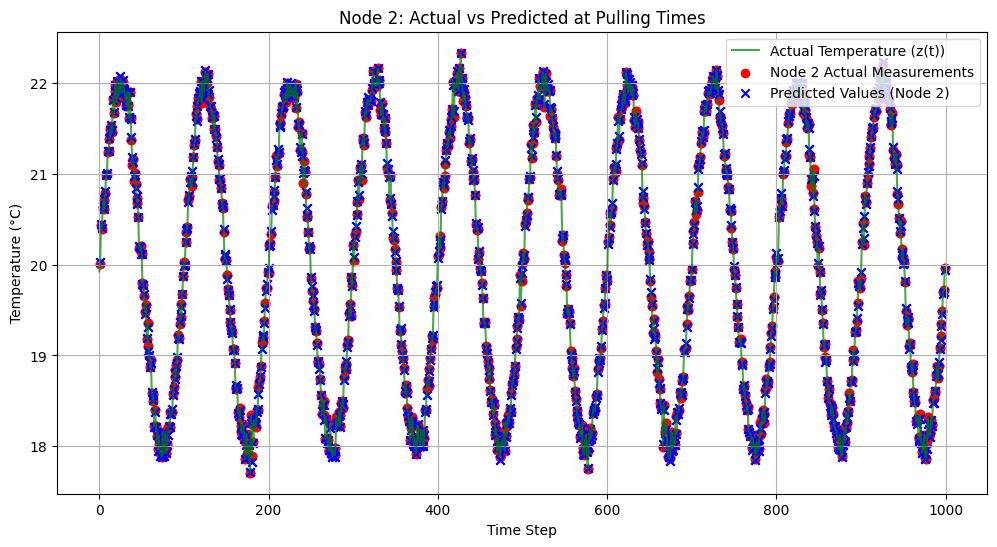

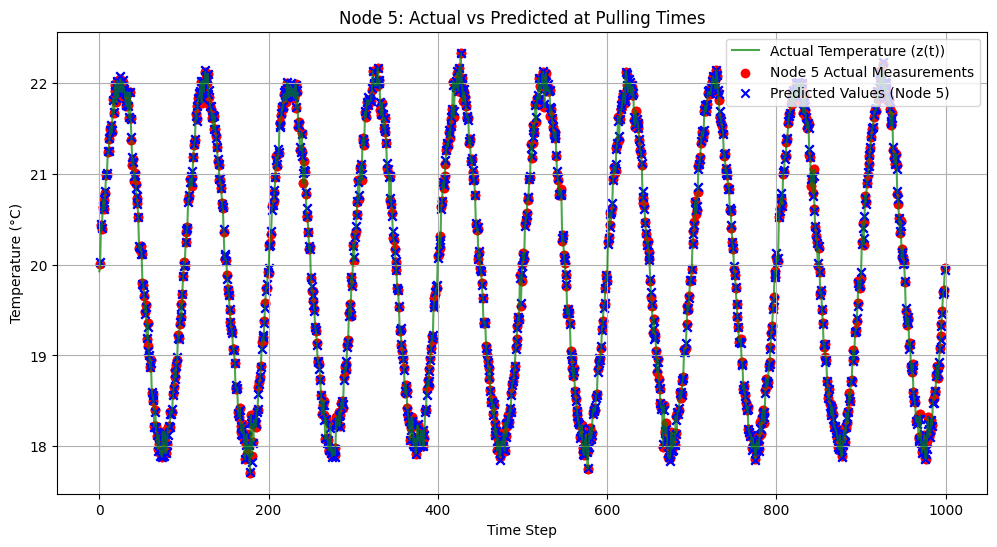

In [279]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Kalman Filter Class
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        self.A = np.array([[1, 1],  # x1 (temperature) evolves by adding x2 (velocity)
                           [0, 1]]) # x2 (velocity) remains constant

        self.H = np.array([[1, 0]])

        self.Q = np.array([[process_variance, 0],
                           [0, process_variance]])

        self.R = np.array([[measurement_variance]])

        self.x_hat = np.array([20.0, 0.5])  # Start with 20°C and 0.1°C per step

        self.P = np.eye(2) * 1  # Initial uncertainty

    def predict(self):
        """ Predict next state and update uncertainty """
        self.x_hat = self.A @ self.x_hat  # State prediction
        self.P = self.A @ self.P @ self.A.T + self.Q  # Uncertainty prediction

    def update(self, measurement):
        """ Update the estimate with a new measurement """
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)  # Kalman Gain
        self.x_hat = self.x_hat + K @ (measurement - self.H @ self.x_hat)  # State update
        self.P = (np.eye(2) - K @ self.H) @ self.P  # Update error covariance

    def get_rate_of_change(self):
        """ Return the estimated rate of change (velocity) """
        return self.x_hat[1]  # x2 (velocity)


# Function to simulate the pull-based system with 10 nodes and polling-based prediction
def multi_node_pull_based_system(z_temp, time_steps, threshold, process_variance, measurement_variance):
    num_nodes = 10
    kalman_filters = {i: KalmanFilter(process_variance, measurement_variance) for i in range(1, num_nodes + 1)}
    last_update_times = {i: 0 for i in range(1, num_nodes + 1)}

    transmission_times = []  # When the node transmits
    sent_times = []  # When actual measurements (z(t)) are sent
    sent_values = []  # Actual z(t) values when sent
    sink_pred_times = []  # Times when the node's prediction was made
    sink_pred_values = []  # Predicted values at the time of polling

    for t in range(1, time_steps):
        node_scores = {}
        
        for node_id in range(1, num_nodes + 1):
            # **Continuous Prediction Step** (Predict for all nodes at every timestep)
            kalman_filters[node_id].predict()
            predicted_value = kalman_filters[node_id].x_hat[0]  # Predicted Temperature
            rate_of_change = kalman_filters[node_id].get_rate_of_change()  # Predicted Rate of Change
            
            # Calculate the pull score (rate_of_change * delta_t)
            delta_t = t - last_update_times[node_id]
            product = abs(rate_of_change) * delta_t
            node_scores[node_id] = product
        
        # **Pull the top 2 nodes with the highest scores**
        selected_nodes = sorted(node_scores, key=node_scores.get, reverse=True)[:2]

        for node_id in selected_nodes:
            measured_value = z_temp[t]  # Simulated real measurement
            kalman_filters[node_id].update(measured_value)  # Update with real data

            # Store transmission times and values
            transmission_times.append(t)
            sink_pred_times.append(t)
            sink_pred_values.append(kalman_filters[node_id].x_hat[0])  # Store predicted value at polling time
            sent_times.append(t)
            sent_values.append(measured_value)

            # Update last pulled time
            last_update_times[node_id] = t

    return transmission_times, sink_pred_times, sink_pred_values, sent_times, sent_values


# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude):
    t = np.arange(0, total_time, time_resolution)
    omega = 2 * np.pi / T_period
    T_dynamic = 2 * np.sin(omega * t) + T_avg  # Dynamic temperature variation
    noise = np.random.normal(0, noise_amplitude, len(t))
    return t, T_dynamic + noise


# Generate the correct time steps based on the total simulation time and resolution
time_resolution = 1  # Ensure this is consistent with the rest of the code
total_time = 1000  # Adjust based on your simulation

# Ensure `t` has the correct shape
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg=20, T_period=100, noise_amplitude=0.1)

# System Parameters
threshold = 0.5  
process_variance = 0.01  
measurement_variance = 0.1  

# Run simulation
transmission_times, sink_pred_times, sink_pred_values, sent_times, sent_values = multi_node_pull_based_system(
    T_realistic, total_time, threshold, process_variance, measurement_variance
)

# **Plot the Results for Only Node 2 and Node 5**
node_ids = [2, 5]  # We are only interested in these nodes

for node_id in node_ids:
    plt.figure(figsize=(12, 6))
    
    # Plot actual temperature
    plt.plot(t, T_realistic[:len(t)], label="Actual Temperature (z(t))", color='green', linestyle='-', alpha=0.7)

    # Plot actual sent values (transmitted z(t) when node was pulled)
    plt.scatter(sent_times, sent_values, color='red', marker='o', label=f"Node {node_id} Actual Measurements")

    # Plot predicted values (Kalman filter prediction at polling time)
    plt.scatter(sink_pred_times, sink_pred_values, color='blue', marker='x', label=f"Predicted Values (Node {node_id})")

    plt.xlabel("Time Step")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Node {node_id}: Actual vs Predicted at Pulling Times")
    plt.legend()
    plt.grid(True)
    plt.show()


In [286]:
import numpy as np

# Kalman Filter Class
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        self.A = np.array([[1, 1],  # x1 (temperature) evolves by adding x2 (velocity)
                           [0, 1]]) # x2 (velocity) remains constant

        self.H = np.array([[1, 0]])

        self.Q = np.array([[process_variance, 0],
                           [0, process_variance]])

        self.R = np.array([[measurement_variance]])

        self.x_hat = np.array([20.0, 0.5])  # Start with 20°C and 0.1°C per step

        self.P = np.eye(2) * 1  # Initial uncertainty

    def predict(self):
        """ Predict next state and update uncertainty """
        self.x_hat = self.A @ self.x_hat  # State prediction
        self.P = self.A @ self.P @ self.A.T + self.Q  # Uncertainty prediction

    def update(self, measurement):
        """ Update the estimate with a new measurement """
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)  # Kalman Gain
        self.x_hat = self.x_hat + K @ (measurement - self.H @ self.x_hat)  # State update
        self.P = (np.eye(2) - K @ self.H) @ self.P  # Update error covariance

    def get_rate_of_change(self):
        """ Return the estimated rate of change (velocity) """
        return self.x_hat[1]  # x2 (velocity)


# Function to simulate the pull-based system with 10 nodes and continuous prediction
def multi_node_pull_based_system(z_temp, time_steps, threshold, process_variance, measurement_variance):
    num_nodes = 10
    kalman_filters = {i: KalmanFilter(process_variance, measurement_variance) for i in range(1, num_nodes + 1)}
    last_update_times = {i: 0 for i in range(1, num_nodes + 1)}

    pull_counts = {i: 0 for i in range(1, num_nodes + 1)}  # Track the number of times each node was pulled

    for t in range(1, time_steps):
        node_scores = {}
        
        for node_id in range(1, num_nodes + 1):
            # **Continuous Prediction Step** (Predict for all nodes at every timestep)
            kalman_filters[node_id].predict()
            predicted_value = kalman_filters[node_id].x_hat[0]  # Predicted Temperature
            rate_of_change = kalman_filters[node_id].get_rate_of_change()  # Predicted Rate of Change
            
            # Calculate the pull score (rate_of_change * delta_t)
            delta_t = t - last_update_times[node_id]
            product = abs(rate_of_change) * delta_t
            node_scores[node_id] = product
        
        # **Pull the top 2 nodes with the highest scores**
        selected_nodes = sorted(node_scores, key=node_scores.get, reverse=True)[:2]

        for node_id in selected_nodes:
            measured_value = z_temp[t]  # Simulated real measurement
            kalman_filters[node_id].update(measured_value)  # Update with real data

            # Increment the pull count for the node
            pull_counts[node_id] += 1

            # Update last pulled time
            last_update_times[node_id] = t

    return pull_counts


# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude):
    t = np.arange(0, total_time, time_resolution)
    omega = 2 * np.pi / T_period
    T_dynamic = 2 * np.sin(omega * t) + T_avg  # Dynamic temperature variation
    noise = np.random.normal(0, noise_amplitude, len(t))
    return t, T_dynamic + noise


# Simulation Parameters
time_resolution = 1
total_time = 1000  # Adjust based on your simulation

# Generate the temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, 20, 100, 0.1)

# System Parameters
threshold = 0.3  # Not used here but included for completeness
process_variance = 0.01
measurement_variance = 0.1

# Run the simulation
pull_counts = multi_node_pull_based_system(T_realistic, total_time, threshold, process_variance, measurement_variance)

# Print out the total number of times each node was pulled
for node_id, count in pull_counts.items():
    print(f"Node {node_id} was pulled {count} times.")


Node 1 was pulled 167 times.
Node 2 was pulled 167 times.
Node 3 was pulled 194 times.
Node 4 was pulled 194 times.
Node 5 was pulled 136 times.
Node 6 was pulled 136 times.
Node 7 was pulled 263 times.
Node 8 was pulled 263 times.
Node 9 was pulled 239 times.
Node 10 was pulled 239 times.


In [289]:
import numpy as np

# Kalman Filter Class
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        self.A = np.array([[1, 1],  # x1 (temperature) evolves by adding x2 (velocity)
                           [0, 1]]) # x2 (velocity) remains constant

        self.H = np.array([[1, 0]])

        self.Q = np.array([[process_variance, 0],
                           [0, process_variance]])

        self.R = np.array([[measurement_variance]])

        self.x_hat = np.array([20.0, 0.5])  # Start with 20°C and 0.1°C per step

        self.P = np.eye(2) * 1  # Initial uncertainty

        self.last_received_time = -1  # Initialize the time of the last received measurement
        self.last_rate_of_change = 0  # Initialize the last rate of change

    def predict(self):
        """ Predict next state and update uncertainty """
        self.x_hat = self.A @ self.x_hat  # State prediction
        self.P = self.A @ self.P @ self.A.T + self.Q  # Uncertainty prediction

    def update(self, measurement, current_time):
        """ Update the estimate with a new measurement """
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)  # Kalman Gain
        self.x_hat = self.x_hat + K @ (measurement - self.H @ self.x_hat)  # State update
        self.P = (np.eye(2) - K @ self.H) @ self.P  # Update error covariance

        # Update the last received time and rate of change after each measurement
        self.last_received_time = current_time
        self.last_rate_of_change = self.x_hat[1]

    def get_rate_of_change(self):
        """ Return the estimated rate of change (velocity) """
        return self.x_hat[1]  # x2 (velocity)


# Function to simulate the pull-based system with 10 nodes and AoII-based decision
def multi_node_pull_based_system(z_temp, time_steps, threshold, process_variance, measurement_variance):
    num_nodes = 10
    kalman_filters = {i: KalmanFilter(process_variance, measurement_variance) for i in range(1, num_nodes + 1)}
    last_update_times = {i: 0 for i in range(1, num_nodes + 1)}

    pull_counts = {i: 0 for i in range(1, num_nodes + 1)}  # Track the number of times each node was pulled

    for t in range(1, time_steps):
        node_scores = {}

        for node_id in range(1, num_nodes + 1):
            # **Continuous Prediction Step** (Predict for all nodes at every timestep)
            kalman_filters[node_id].predict()
            predicted_value = kalman_filters[node_id].x_hat[0]  # Predicted Temperature
            rate_of_change = kalman_filters[node_id].get_rate_of_change()  # Predicted Rate of Change

            # Calculate the AoII (same as rate_of_change * delta_t)
            delta_t = t - last_update_times[node_id]
            aoii = abs(rate_of_change) * delta_t

            # If the AoII exceeds the threshold, calculate the pull score
            if aoii > threshold:
                node_scores[node_id] = aoii  # Store AoII value as the score

        # **Sort nodes by AoII** to decide the top 2 nodes
        sorted_nodes = sorted(node_scores.items(), key=lambda x: x[1], reverse=True)  # Sort by AoII in descending order
        selected_nodes = [node for node, _ in sorted_nodes[:2]]  # Select the top 2 nodes with the highest AoII

        for node_id in selected_nodes:
            measured_value = z_temp[t]  # Simulated real measurement
            kalman_filters[node_id].update(measured_value, t)  # Update with real data

            # Increment the pull count for the node
            pull_counts[node_id] += 1

            # Update last pulled time
            last_update_times[node_id] = t

    return pull_counts


# Generate a realistic temperature signal
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude):
    t = np.arange(0, total_time, time_resolution)
    omega = 2 * np.pi / T_period
    T_dynamic = 2 * np.sin(omega * t) + T_avg  # Dynamic temperature variation
    noise = np.random.normal(0, noise_amplitude, len(t))
    return t, T_dynamic + noise


# Simulation Parameters
time_resolution = 1
total_time = 1000  # Adjust based on your simulation

# Generate the temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, 20, 100, 0.1)

# System Parameters
threshold = 0.3  # AoII threshold for pulling
process_variance = 0.01
measurement_variance = 0.1

# Run the simulation
pull_counts = multi_node_pull_based_system(T_realistic, total_time, threshold, process_variance, measurement_variance)

# Print out the total number of times each node was pulled
for node_id, count in pull_counts.items():
    print(f"Node {node_id} was pulled {count} times.")


Node 1 was pulled 116 times.
Node 2 was pulled 116 times.
Node 3 was pulled 25 times.
Node 4 was pulled 25 times.
Node 5 was pulled 137 times.
Node 6 was pulled 137 times.
Node 7 was pulled 119 times.
Node 8 was pulled 119 times.
Node 9 was pulled 118 times.
Node 10 was pulled 118 times.


In [313]:
import numpy as np

# Kalman Filter Class
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        self.A = np.array([[1, 1],  # x1 (temperature) evolves by adding x2 (velocity)
                           [0, 1]]) # x2 (velocity) remains constant

        self.H = np.array([[1, 0]])

        self.Q = np.array([[process_variance, 0],
                           [0, process_variance]])

        self.R = np.array([[measurement_variance]])

        self.x_hat = np.array([20.0, 0.5])  # Start with 20°C and 0.1°C per step

        self.P = np.eye(2) * 1  # Initial uncertainty

        self.last_received_time = -1  # Initialize the time of the last received measurement
        self.last_rate_of_change = 0  # Initialize the last rate of change

    def predict(self):
        """ Predict next state and update uncertainty """
        self.x_hat = self.A @ self.x_hat  # State prediction
        self.P = self.A @ self.P @ self.A.T + self.Q  # Uncertainty prediction

    def update(self, measurement, current_time):
        """ Update the estimate with a new measurement """
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)  # Kalman Gain
        self.x_hat = self.x_hat + K @ (measurement - self.H @ self.x_hat)  # State update
        self.P = (np.eye(2) - K @ self.H) @ self.P  # Update error covariance

        # Update the last received time and rate of change after each measurement
        self.last_received_time = current_time
        self.last_rate_of_change = self.x_hat[1]

    def get_rate_of_change(self):
        """ Return the estimated rate of change (velocity) """
        return self.x_hat[1]  # x2 (velocity)


# Function to simulate the pull-based system with 10 nodes and AoII-based decision
def multi_node_pull_based_system(z_temp, time_steps, threshold, process_variance, measurement_variance):
    num_nodes = 10
    kalman_filters = {i: KalmanFilter(process_variance, measurement_variance) for i in range(1, num_nodes + 1)}
    last_update_times = {i: 0 for i in range(1, num_nodes + 1)}

    pull_counts = {i: 0 for i in range(1, num_nodes + 1)}  # Track the number of times each node was pulled

    for t in range(1, time_steps):
        node_scores = {}

        for node_id in range(1, num_nodes + 1):
            # **Continuous Prediction Step** (Predict for all nodes at every timestep)
            kalman_filters[node_id].predict()
            predicted_value = kalman_filters[node_id].x_hat[0]  # Predicted Temperature
            rate_of_change = kalman_filters[node_id].get_rate_of_change()  # Predicted Rate of Change

            # Calculate the AoII (same as rate_of_change * delta_t)
            delta_t = t - last_update_times[node_id]
            aoii = abs(rate_of_change) * delta_t

            # If the AoII exceeds the threshold, calculate the pull score
            if aoii > threshold:
                node_scores[node_id] = aoii  # Store AoII value as the score

        # **Sort nodes by AoII** to decide the top 2 nodes
        sorted_nodes = sorted(node_scores.items(), key=lambda x: x[1], reverse=True)  # Sort by AoII in descending order
        selected_nodes = [node for node, _ in sorted_nodes[:2]]  # Select the top 2 nodes with the highest AoII

        for node_id in selected_nodes:
            measured_value = z_temp[t]  # Simulated real measurement
            kalman_filters[node_id].update(measured_value, t)  # Update with real data

            # Increment the pull count for the node
            pull_counts[node_id] += 1

            # Update last pulled time
            last_update_times[node_id] = t

    return pull_counts


# Modify the temperature signal generation to apply different periods for nodes 7, 8, 9, 10
def generate_realistic_temperature_signal_with_diff_periods(total_time, time_resolution, T_avg, slow_period, fast_period, noise_amplitude, high_noise_nodes):
    t = np.arange(0, total_time, time_resolution)
    omega_slow = 2 * np.pi / slow_period
    omega_fast = 2 * np.pi / fast_period
    
    T_dynamic = np.zeros_like(t)
    
    # Generate temperature signals for nodes
    for i in range(len(t)):
        for node in range(1, 11):  # Loop over all nodes
            if node in high_noise_nodes:
                # Nodes 7, 8, 9, 10 (fast period)
                T_dynamic[i] += np.sin(omega_fast * t[i])
            else:
                # The rest of the nodes (slow period)
                T_dynamic[i] += np.sin(omega_slow * t[i])
    
    noise = np.random.normal(0, noise_amplitude, len(t))
    return t, T_dynamic + noise


# Simulation Parameters
time_resolution = 1
total_time = 5000  # Total time for the simulation

# High noise nodes (7, 8, 9, 10) and their noise amplitude
high_noise_nodes = [7, 8, 9, 10]
normal_noise_amplitude = 0.2  # Default noise amplitude for other nodes
slow_period = 500  # Slow period for nodes 1-6
fast_period = 50  # Fast period for nodes 7-10

# Generate the temperature signal with different periods
t, T_realistic = generate_realistic_temperature_signal_with_diff_periods(
    total_time, time_resolution, 20, slow_period, fast_period, normal_noise_amplitude, high_noise_nodes
)

# System Parameters
threshold = 0.5 # AoII threshold for pulling
process_variance = 0.01
measurement_variance = 0.5

# Run the simulation
pull_counts = multi_node_pull_based_system(T_realistic, total_time, threshold, process_variance, measurement_variance)

# Print out the total number of times each node was pulled
for node_id, count in pull_counts.items():
    print(f"Node {node_id} was pulled {count} times.")


Node 1 was pulled 15 times.
Node 2 was pulled 15 times.
Node 3 was pulled 16 times.
Node 4 was pulled 16 times.
Node 5 was pulled 11 times.
Node 6 was pulled 11 times.
Node 7 was pulled 13 times.
Node 8 was pulled 13 times.
Node 9 was pulled 14 times.
Node 10 was pulled 14 times.


In [325]:
import numpy as np

# Kalman Filter Class
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        self.A = np.array([[1, 1],  # x1 (temperature) evolves by adding x2 (velocity)
                           [0, 1]]) # x2 (velocity) remains constant

        self.H = np.array([[1, 0]])

        self.Q = np.array([[process_variance, 0],
                           [0, process_variance]])

        self.R = np.array([[measurement_variance]])

        self.x_hat = np.array([20.0, 0.5])  # Start with 20°C and 0.1°C per step

        self.P = np.eye(2) * 1  # Initial uncertainty

        self.last_received_time = -1  # Initialize the time of the last received measurement
        self.last_rate_of_change = 0  # Initialize the last rate of change

    def predict(self):
        """ Predict next state and update uncertainty """
        self.x_hat = self.A @ self.x_hat  # State prediction
        self.P = self.A @ self.P @ self.A.T + self.Q  # Uncertainty prediction

    def update(self, measurement, current_time):
        """ Update the estimate with a new measurement """
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)  # Kalman Gain
        self.x_hat = self.x_hat + K @ (measurement - self.H @ self.x_hat)  # State update
        self.P = (np.eye(2) - K @ self.H) @ self.P  # Update error covariance

        # Update the last received time and rate of change after each measurement
        self.last_received_time = current_time
        self.last_rate_of_change = self.x_hat[1]

    def get_rate_of_change(self):
        """ Return the estimated rate of change (velocity) """
        return self.x_hat[1]  # x2 (velocity)


# Function to simulate the pull-based system with 10 nodes, selecting the top 2 with the highest AoII
def multi_node_pull_based_system(z_temp, time_steps, process_variance, measurement_variance):
    num_nodes = 10
    kalman_filters = {i: KalmanFilter(process_variance, measurement_variance) for i in range(1, num_nodes + 1)}
    last_update_times = {i: 0 for i in range(1, num_nodes + 1)}

    pull_counts = {i: 0 for i in range(1, num_nodes + 1)}  # Track the number of times each node was pulled

    for t in range(1, time_steps):
        node_scores = {}

        for node_id in range(1, num_nodes + 1):
            # **Continuous Prediction Step** (Predict for all nodes at every timestep)
            kalman_filters[node_id].predict()
            predicted_value = kalman_filters[node_id].x_hat[0]  # Predicted Temperature
            rate_of_change = kalman_filters[node_id].get_rate_of_change()  # Predicted Rate of Change

            # Calculate the AoII (rate_of_change * delta_t)
            delta_t = t - last_update_times[node_id]
            aoii = abs(rate_of_change) * delta_t

            # Store AoII value as the score
            node_scores[node_id] = aoii  

        # **Sort nodes by AoII** and select the top 2
        sorted_nodes = sorted(node_scores.items(), key=lambda x: x[1], reverse=True)  # Sort by AoII in descending order
        selected_nodes = [node for node, _ in sorted_nodes[:2]]  # Select the top 2 nodes with the highest AoII

        for node_id in selected_nodes:
            measured_value = z_temp[t]  # Simulated real measurement
            kalman_filters[node_id].update(measured_value, t)  # Update with real data

            # Increment the pull count for the node
            pull_counts[node_id] += 1

            # Update last pulled time
            last_update_times[node_id] = t

    return pull_counts


# Modify the temperature signal generation to apply different periods and noise amplitudes for nodes 7, 8, 9, 10
def generate_realistic_temperature_signal_with_diff_periods_and_noise(
    total_time, time_resolution, T_avg, slow_period, fast_period, noise_amplitude, high_noise_nodes, high_noise_amplitude):
    
    t = np.arange(0, total_time, time_resolution)
    omega_slow = 2 * np.pi / slow_period
    omega_fast = 2 * np.pi / fast_period
    
    T_dynamic = np.zeros_like(t)
    
    # Generate temperature signals for nodes
    for i in range(len(t)):
        for node in range(1, 11):  # Loop over all nodes
            if node in high_noise_nodes:
                # Nodes 7, 8, 9, 10 (fast period with high noise)
                T_dynamic[i] += np.sin(omega_fast * t[i]) + np.random.normal(0, high_noise_amplitude)  # Higher noise for these nodes
            else:
                # The rest of the nodes (slow period)
                T_dynamic[i] += np.sin(omega_slow * t[i])
    
    noise = np.random.normal(0, noise_amplitude, len(t))
    return t, T_dynamic + noise


# Simulation Parameters
time_resolution = 1
total_time = 5000  # Total time for the simulation

# High noise nodes (7, 8, 9, 10) with faster oscillations
high_noise_nodes = [7, 8, 9, 10]
normal_noise_amplitude = 0.2  # Default noise amplitude for other nodes
high_noise_amplitude = 1.0  # Increased noise amplitude for high noise nodes
slow_period = 500  # Slow period for nodes 1-6
fast_period = 50  # Fast period for nodes 7-10

# Generate the temperature signal with different periods and higher noise amplitude for specific nodes
t, T_realistic = generate_realistic_temperature_signal_with_diff_periods_and_noise(
    total_time, time_resolution, 20, slow_period, fast_period, normal_noise_amplitude, high_noise_nodes, high_noise_amplitude
)

# System Parameters
process_variance = 0.01
measurement_variance = 0.5

# Run the simulation
pull_counts = multi_node_pull_based_system(T_realistic, total_time, process_variance, measurement_variance)

# Print out the total number of times each node was pulled
for node_id, count in pull_counts.items():
    print(f"Node {node_id} was pulled {count} times.")



Node 1 was pulled 820 times.
Node 2 was pulled 820 times.
Node 3 was pulled 992 times.
Node 4 was pulled 992 times.
Node 5 was pulled 1183 times.
Node 6 was pulled 1183 times.
Node 7 was pulled 817 times.
Node 8 was pulled 817 times.
Node 9 was pulled 1187 times.
Node 10 was pulled 1187 times.


In [367]:
import numpy as np

# Helper function to update sink state using dEWMA
def update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_sink_value + last_sink_rate * delta_t)
    x2 = beta_2 * (x1 - last_sink_value) / delta_t + (1 - beta_2) * last_sink_rate
    return x1, x2

# Function to simulate the pull-based system (sink-side processing)
def pull_based_system_sink_dewma(z_temp, time_steps, threshold, beta_1, beta_2):
    transmission_times = []  # Time steps when the node transmits
    transmitted_values = []  # (Time, z(t))
    sink_predictions = []  # (Time, Predicted x1 at pull time)

    # Initial conditions for the sink
    last_received_measurement = z_temp[0, 0]  # First received measurement for Node 1
    last_sink_value = z_temp[0, 0]
    last_sink_rate = 0.4  # Set initial rate of change to 1 (high enough to allow pulls at the start)
    last_transmission_time = 0  # When last z(t) was received
    last_update_times = {i: 0 for i in range(1, 11)}  # Initialize last update times for all nodes

    # Track the number of pulls for each node
    pull_counts = {i: 0 for i in range(1, 11)}

    # Initialize rate_of_change for all nodes as high initially to allow the first pulls
    node_rates = {i: 1 for i in range(1, 11)}  # Initial rate of change for all nodes

    for t in range(1, time_steps):
        node_scores = {}  # To store AoII values for each node
        selected_nodes = []

        # Calculate AoII for each node (based on rate of change)
        for node_id in range(1, 11):
            delta_t = t - last_update_times[node_id]  # Time since last transmission

            # If rate_of_change is 0, AoII will be 0, meaning no pull will happen for that node
            aoii = abs(last_sink_rate) * delta_t  # Absolute AoII based on the rate of change and delta_t
            
            # Ensure AoII is a scalar value, not an array
            node_scores[node_id] = float(aoii)  # Convert AoII to scalar (in case of array-like issues)

        # Sort nodes by AoII and select the top 2 nodes
        sorted_nodes = sorted(node_scores.items(), key=lambda x: x[1], reverse=True)

        # Select top 2 nodes that exceed the threshold and have a non-zero rate of change
        for node, aoii in sorted_nodes[:2]:
            if aoii > threshold:  # Only pull nodes with a significant AoII
                selected_nodes.append(node)

        # For each selected node, update state and track pulls
        for node_id in selected_nodes:
            measured_value = z_temp[t, node_id - 1]  # Simulated real measurement for the selected node
            # Update sink using dEWMA for selected nodes
            x1, x2 = update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2)

            # Store transmission times and values
            transmission_times.append(t)
            transmitted_values.append((t, measured_value))

            # Store sink's predicted value at the time of pull
            sink_predictions.append((t, last_sink_value))

            # Update the last received values for selected nodes
            last_received_measurement = measured_value
            last_sink_value = x1
            last_sink_rate = x2
            last_update_times[node_id] = t  # Update last update time

            # Increment pull count for the selected node
            pull_counts[node_id] += 1

    return transmission_times, transmitted_values, sink_predictions, pull_counts



# Generate a realistic temperature signal (nodes 1-6 flat, nodes 7-10 dynamic)
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    
    # Nodes 1-6 stay flat at 20 degrees (from start to end)
    T_flat_nodes = np.full_like(t, 20)
    
    # Nodes 7-10 have dynamic temperature variation
    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    # Combine flat and dynamic temperature signals
    T_realistic = np.zeros((len(t), 10))  # 10 nodes
    T_realistic[:, :6] = T_flat_nodes[:, np.newaxis]  # Nodes 1-6 (flat at 20 degrees)
    T_realistic[:, 6:] = T_dynamic[:, np.newaxis]  # Nodes 7-10 (dynamic)
    
    # Add noise and disturbances only to the dynamic nodes (7-10)
    T_realistic[:, 6:] += noise[:, np.newaxis] + disturbances[:, np.newaxis]  # Add noise and disturbances

    return t, T_realistic

# Simulation Parameters
total_time = 5000  # Set total time to 5000 steps
time_resolution = 1  
T_avg = 20  
T_period = 100  
noise_amplitude = 0.1  
disturbance_probability = 0 

# Generate the temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# System Parameters
threshold = 0.5  
beta_1 = 0.3
beta_2 = 0.3

# Run the pull-based system simulation (sink-side processing)
transmission_times, transmitted_values, sink_predictions, pull_counts = pull_based_system_sink_dewma(
    T_realistic, total_time, threshold, beta_1, beta_2
)

# Print the number of times each node was pulled
for node_id, count in pull_counts.items():
    print(f"Node {node_id} was pulled {count} times.")


Node 1 was pulled 3 times.
Node 2 was pulled 3 times.
Node 3 was pulled 3 times.
Node 4 was pulled 3 times.
Node 5 was pulled 3 times.
Node 6 was pulled 3 times.
Node 7 was pulled 3 times.
Node 8 was pulled 3 times.
Node 9 was pulled 2 times.
Node 10 was pulled 2 times.


In [381]:
import numpy as np

# Helper function to update sink state using dEWMA
def update_sink_state_dewma(measured_value, last_sink_value, last_sink_rate, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_sink_value + last_sink_rate * delta_t)
    x2 = beta_2 * (x1 - last_sink_value) / delta_t + (1 - beta_2) * last_sink_rate
    return x1, x2

# Function to simulate the pull-based system (sink-side processing)
def pull_based_system_sink_dewma(z_temp, time_steps, threshold, beta_1, beta_2):
    transmission_times = []  # Time steps when the node transmits
    transmitted_values = []  # (Time, z(t))
    sink_predictions = []  # (Time, Predicted x1 at pull time)

    # Initialize conditions for each node
    last_sink_values = {i: z_temp[0, i - 1] for i in range(1, 11)}  # Initial values for all nodes
    last_sink_rates = {i: 0.1 for i in range(1, 11)}  # Initial rate of change set to 0.1 for all nodes
    last_update_times = {i: 0 for i in range(1, 11)}  # Initialize last update times for all nodes

    # Track the number of pulls for each node
    pull_counts = {i: 0 for i in range(1, 11)}

    # Simulate each time step
    for t in range(1, time_steps):
        node_scores = {}  # To store AoII values for each node
        selected_nodes = []

        # Calculate AoII for each node (based on rate of change)
        for node_id in range(1, 11):
            delta_t = t - last_update_times[node_id]  # Time since last transmission

            # Calculate AoII for the node (based on rate of change)
            aoii = abs(last_sink_rates[node_id]) * delta_t  # Absolute AoII based on the rate of change and delta_t
            node_scores[node_id] = float(aoii)  # Store AoII value as a scalar

        # Sort nodes by AoII and select the top 2 nodes to pull
        sorted_nodes = sorted(node_scores.items(), key=lambda x: x[1], reverse=True)

        # Select top 2 nodes (to pull regardless of whether their AoII exceeds the threshold)
        for node, aoii in sorted_nodes[:2]:
            selected_nodes.append(node)

        # For each selected node, update state and track pulls
        for node_id in selected_nodes:
            measured_value = z_temp[t, node_id - 1]  # Simulated real measurement for the selected node
            # Update sink using dEWMA for selected nodes
            x1, x2 = update_sink_state_dewma(measured_value, last_sink_values[node_id], last_sink_rates[node_id], delta_t, beta_1, beta_2)

            # Store transmission times and values
            transmission_times.append(t)
            transmitted_values.append((t, measured_value))

            # Store sink's predicted value at the time of pull
            sink_predictions.append((t, last_sink_values[node_id]))

            # Update the last received values for selected nodes
            last_sink_values[node_id] = x1
            last_sink_rates[node_id] = x2  # Update rate of change for the selected node
            last_update_times[node_id] = t  # Update last update time for the pulled node

            # Increment pull count for the selected node
            pull_counts[node_id] += 1

    return transmission_times, transmitted_values, sink_predictions, pull_counts



# Generate temperature signal (nodes 1-6 are flat after time step 5000, and others vary)
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)
    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period
    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    # Nodes 1-6 stay flat after time step 5000
    T_dynamic[5000:] = 20  # Flat temperature from time 5000 onwards for nodes 1-6

    # Reshape T_dynamic for nodes 7-10
    T_realistic = np.zeros((len(t), 10))  # 10 nodes
    T_realistic[:, :6] = 20  # Nodes 1-6 (flat at 20 degrees)
    T_realistic[:, 6:] = np.column_stack([T_dynamic + noise + disturbances for _ in range(4)])  # Nodes 7-10 (dynamic)

    return t, T_realistic


# Simulation Parameters
total_time = 5000  # Adjusted for simulation time
time_resolution = 1
T_avg = 20
T_period = 100
noise_amplitude = 0.1
disturbance_probability = 0

# Generate the temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# System Parameters
threshold = 0.5  # AoII threshold
beta_1 = 0.3  # dEWMA beta_1
beta_2 = 0.3  # dEWMA beta_2

# Run the pull-based system simulation (sink-side processing)
transmission_times, transmitted_values, sink_predictions, pull_counts = pull_based_system_sink_dewma(
    T_realistic, total_time, threshold, beta_1, beta_2
)

# Print the number of times each node was pulled
for node_id, count in pull_counts.items():
    print(f"Node {node_id} was pulled {count} times.")



Node 1 was pulled 67 times.
Node 2 was pulled 67 times.
Node 3 was pulled 40 times.
Node 4 was pulled 40 times.
Node 5 was pulled 72 times.
Node 6 was pulled 72 times.
Node 7 was pulled 2353 times.
Node 8 was pulled 2353 times.
Node 9 was pulled 2467 times.
Node 10 was pulled 2467 times.
